In [1]:
import matplotlib.pyplot as plt
import pandas
import statistics
import numpy 
import math
import scipy
import statistics

pandas.options.display.float_format = '{:20,.4f}'.format
numpy.set_printoptions(formatter={'float_kind': "{:.2f}".format})
plt.style.use('dark_background')

# Data Integration

In [2]:
AppStore = pandas.read_csv('appleAppData.csv') 
#loading from file in local folder

In [3]:
PlayStore = pandas.read_csv('Google-Playstore.csv',
                            usecols=["App Name","App Id","Category","Rating","Rating Count","Minimum Installs","Maximum Installs","Free","Price","Size","Developer Id","Released","Last Updated","Content Rating","Ad Supported","In App Purchases","Editors Choice","Scraped Time"],
                            dtype={'Installs':'category', 'Category':'category','Content Rating':'category',
                            'Rating':'float16', 'Rating Count':'float32', 'Price':'float16',})
#loading from file in local folder

In [4]:
PlayStore['Released'] = pandas.to_datetime(PlayStore['Released'], format='%b %d, %Y')
PlayStore['Last Updated'] = pandas.to_datetime(PlayStore['Last Updated'], format='%b %d, %Y')
PlayStore['Scraped Time'] = pandas.to_datetime(PlayStore['Scraped Time'], format='%Y-%m-%d %H:%M:%S')

def size_to_kilobytes(a):
    try:
        if math.isnan(a) or a=='Varies with device': return
    except:
        if "G" in a: 
            if ',' in a: a = a.replace(',' , '')
            return float(a[:-1])*1_000_000
        elif "M" in a: 
            if ',' in a: a = a.replace(',' , '')
            return float(a[:-1])*1_000
        elif "k" in a: 
            if ',' in a: a = a.replace(',' , '')
            return float(a[:-1]) 

PlayStore['Size in kilobytes'] = PlayStore['Size'].apply(lambda x: size_to_kilobytes(x))
PlayStore = PlayStore[PlayStore['Maximum Installs'] > 0]
PlayStore.loc[PlayStore['Price']==0.0, 'Free'] = True

PlayStore.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2301355 entries, 0 to 2312943
Data columns (total 19 columns):
 #   Column             Dtype         
---  ------             -----         
 0   App Name           object        
 1   App Id             object        
 2   Category           category      
 3   Rating             float16       
 4   Rating Count       float32       
 5   Minimum Installs   float64       
 6   Maximum Installs   int64         
 7   Free               bool          
 8   Price              float16       
 9   Size               object        
 10  Developer Id       object        
 11  Released           datetime64[ns]
 12  Last Updated       datetime64[ns]
 13  Content Rating     category      
 14  Ad Supported       bool          
 15  In App Purchases   bool          
 16  Editors Choice     bool          
 17  Scraped Time       datetime64[ns]
 18  Size in kilobytes  float64       
dtypes: bool(4), category(2), datetime64[ns](3), float16(2), float32

In [5]:
AppStore['Primary_Genre'] = AppStore['Primary_Genre'].astype('category')
AppStore['Content_Rating'] = AppStore['Content_Rating'].astype('category')

AppStore['Released'] = pandas.to_datetime(AppStore['Released'], format='%Y-%m-%dT%H:%M:%S')
AppStore['Updated'] = pandas.to_datetime(AppStore['Updated'], format='%Y-%m-%dT%H:%M:%S')

AppStore.drop(columns=['Current_Version_Score','Current_Version_Reviews','Required_IOS_Version','Developer_Website', 'Developer_Url','Currency'], inplace=True)
AppStore.drop(columns=['Version'], inplace=True)
AppStore.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230376 entries, 0 to 1230375
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype              
---  ------               --------------    -----              
 0   App_Id               1230376 non-null  object             
 1   App_Name             1230375 non-null  object             
 2   AppStore_Url         1230376 non-null  object             
 3   Primary_Genre        1230376 non-null  category           
 4   Content_Rating       1230376 non-null  category           
 5   Size_Bytes           1230152 non-null  float64            
 6   Released             1230373 non-null  datetime64[ns, UTC]
 7   Updated              1230376 non-null  datetime64[ns, UTC]
 8   Price                1229886 non-null  float64            
 9   Free                 1230376 non-null  bool               
 10  DeveloperId          1230376 non-null  int64              
 11  Developer            1230376 non-null  object     

# Handling Missing and Duplicated Data

## PlayStore

In [6]:
PlayStore.info(null_counts=True)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2301355 entries, 0 to 2312943
Data columns (total 19 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   App Name           2301353 non-null  object        
 1   App Id             2301355 non-null  object        
 2   Category           2301355 non-null  category      
 3   Rating             2278748 non-null  float16       
 4   Rating Count       2278748 non-null  float32       
 5   Minimum Installs   2301271 non-null  float64       
 6   Maximum Installs   2301355 non-null  int64         
 7   Free               2301355 non-null  bool          
 8   Price              2301355 non-null  float16       
 9   Size               2301161 non-null  object        
 10  Developer Id       2301322 non-null  object        
 11  Released           2230856 non-null  datetime64[ns]
 12  Last Updated       2301355 non-null  datetime64[ns]
 13  Content Rating     2301355 

In [7]:
PlayStore['App Id'].duplicated(keep=False).sum()    # no duplicates
PlayStore['App Name'].duplicated(keep=False).sum()  # 201556 duplicates
len(PlayStore['Developer Id'].unique())             # 756087 unique developers

756088

In [8]:
def min_installs_imputation(num):
    arr = [0, 1.0, 5.0, 10.0, 50.0, 100.0,500.0,1000.0,5000.0, 10000.0,50000.0,100000.0,500000.0, 1000000.0,5000000.0,10000000.0,50000000.0,100000000.0,500000000.0,1000000000.0,5000000000.0,10000000000.0]
    for i in range(len(arr)):
        if arr[i]>num: return arr[i-1]
    return

PlayStore.loc[PlayStore['Minimum Installs'].isnull(), 'Minimum Installs'] = PlayStore.loc[PlayStore['Minimum Installs'].isnull(), 'Maximum Installs'].apply(min_installs_imputation)
PlayStore.loc[PlayStore['Developer Id'].isnull(), 'Developer Id'] = 'Unknown'
PlayStore.loc[PlayStore['Rating Count'].isnull(), 'Rating Count'] = 0
PlayStore.loc[PlayStore['Rating'].isnull(), 'Rating'] = 0
PlayStore.loc[PlayStore['Released'].isna(), 'Released'] = PlayStore.loc[PlayStore['Released'].isna(), 'Last Updated']

We impute the minimum installs ourselves

We also define new developer ID "UNKNOWN" as value for NA

Not all apps have 'Rating', but we find that rating count especially in case of install does not affect significantly.
Thus we are okay with absence of rating.

Also 'Minimum Installs' and 'Install' columns have missing values as well, but as we have 'Maximum Installs' column cells full, we will ignore those columns.

Missing data only does not appear on non-significant columns.

## AppStore

In [9]:
AppStore.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230376 entries, 0 to 1230375
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype              
---  ------               --------------    -----              
 0   App_Id               1230376 non-null  object             
 1   App_Name             1230375 non-null  object             
 2   AppStore_Url         1230376 non-null  object             
 3   Primary_Genre        1230376 non-null  category           
 4   Content_Rating       1230376 non-null  category           
 5   Size_Bytes           1230152 non-null  float64            
 6   Released             1230373 non-null  datetime64[ns, UTC]
 7   Updated              1230376 non-null  datetime64[ns, UTC]
 8   Price                1229886 non-null  float64            
 9   Free                 1230376 non-null  bool               
 10  DeveloperId          1230376 non-null  int64              
 11  Developer            1230376 non-null  object     

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


We can seee that 'App Name' has 1 missing value

'Released' has several missing data, which we will impute with Updated Date!

'Price' column has 490 missing values

In [10]:
AppStore[AppStore['Price'].isnull()]['Free'].sum()

0

All price missing rows indicated their 'Free' column as FALSE, thus we will impute with indication !!!!

In [11]:
AppStore['isMissingPrice'] = False
AppStore.loc[AppStore['Price'].isnull(), 'isMissingPrice'] = True
AppStore[AppStore['Price'].isnull()].head()
# do not run this code snippet more than ONE time!

,App_Id,App_Name,AppStore_Url,Primary_Genre,Content_Rating,Size_Bytes,Released,Updated,Price,Free,DeveloperId,Developer,Average_User_Rating,Reviews,isMissingPrice
37719,yesholistic.ios-app,YesHolistic,https://apps.apple.com/us/app/yesholistic/id15...,Business,17+,"13,234,176.0000",2021-10-18 07:00:00+00:00,2021-10-18 07:00:00+00:00,NaN,False,1476184584,Shahar Hillel,0.0000,0,True
41977,com.gameshub.ios.pagesuntoldstories,Love Fantasy: Romance Episode,https://apps.apple.com/us/app/love-fantasy-rom...,Games,17+,"205,370,368.0000",2022-01-18 08:00:00+00:00,2022-01-18 08:00:00+00:00,NaN,False,1560073415,Games Hub Hong Kong Limited,0.0000,0,True
55166,yomi.studio.art.story.picture.novels.puzzle.fr...,Art Story: Color Jigsaw Novels,https://apps.apple.com/us/app/art-story-color-...,Games,9+,"333,257,728.0000",2021-10-30 07:00:00+00:00,2021-10-30 07:00:00+00:00,NaN,False,1089048778,Yomi Studio,0.0000,0,True
63162,com.coloringbook.kids,Baby coloring book for kids,https://apps.apple.com/us/app/baby-coloring-bo...,Education,4+,"42,468,352.0000",2021-11-13 08:00:00+00:00,2021-11-13 08:00:00+00:00,NaN,False,300297127,Advanced Studio LLC,0.0000,0,True
98305,com.invogue.naughtybaby,Baby Jr - Da new boss in house,https://apps.apple.com/us/app/baby-jr-da-new-b...,Games,4+,"455,131,136.0000",2021-10-29 07:00:00+00:00,2021-10-29 07:00:00+00:00,NaN,False,1149339300,Nadeem Munawar,0.0000,0,True


In [12]:
AppStore.loc[AppStore['Price'].isnull(), 'Price'] = 0
AppStore.loc[AppStore['Price'].isnull(), 'Free'] = True
AppStore.loc[AppStore['Released'].isnull(), 'Free'] = True
AppStore.loc[AppStore['Released'].isnull(), 'Released'] = AppStore.loc[AppStore['Released'].isnull(), 'Updated']
AppStore['Size_Megabytes'] = AppStore['Size_Bytes']/1_000_000

In [13]:
AppStore['App_Id'].duplicated(keep=False).sum()         # no duplicates for ID
AppStore['App_Name'].duplicated(keep=False).sum()       # 13365 name duplicates
AppStore['AppStore_Url'].duplicated(keep=False).sum()   # no url duplicates
len(AppStore['Developer'].unique())                     # 505255 unique devs

505255

In [14]:
AppStore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230376 entries, 0 to 1230375
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype              
---  ------               --------------    -----              
 0   App_Id               1230376 non-null  object             
 1   App_Name             1230375 non-null  object             
 2   AppStore_Url         1230376 non-null  object             
 3   Primary_Genre        1230376 non-null  category           
 4   Content_Rating       1230376 non-null  category           
 5   Size_Bytes           1230152 non-null  float64            
 6   Released             1230376 non-null  datetime64[ns, UTC]
 7   Updated              1230376 non-null  datetime64[ns, UTC]
 8   Price                1230376 non-null  float64            
 9   Free                 1230376 non-null  bool               
 10  DeveloperId          1230376 non-null  int64              
 11  Developer            1230376 non-null  object     

# Outliers

## PlayStore

In [15]:
PlayStore.describe()

,Rating,Rating Count,Minimum Installs,Maximum Installs,Price,Size in kilobytes
count,"2,301,355.0000","2,301,355.0000","2,301,355.0000","2,301,355.0000","2,301,355.0000","2,226,706.0000"
mean,NaN,"2,850.7771","184,361.8492","321,814.1622",NaN,"19,202.9871"
std,0.0000,"211,641.4219","15,169,133.7116","23,614,177.6316",NaN,"24,015.8653"
min,0.0000,0.0000,1.0000,1.0000,0.0000,3.2000
25%,0.0000,0.0000,50.0000,87.0000,0.0000,"4,900.0000"
50%,2.9004,6.0000,500.0000,710.0000,0.0000,"10,000.0000"
75%,4.3008,41.0000,"5,000.0000","7,457.0000",0.0000,"25,000.0000"
max,5.0000,"138,557,568.0000","10,000,000,000.0000","12,057,627,016.0000",400.0000,"1,500,000.0000"


Text(0, 0.5, 'Quantity of apps')

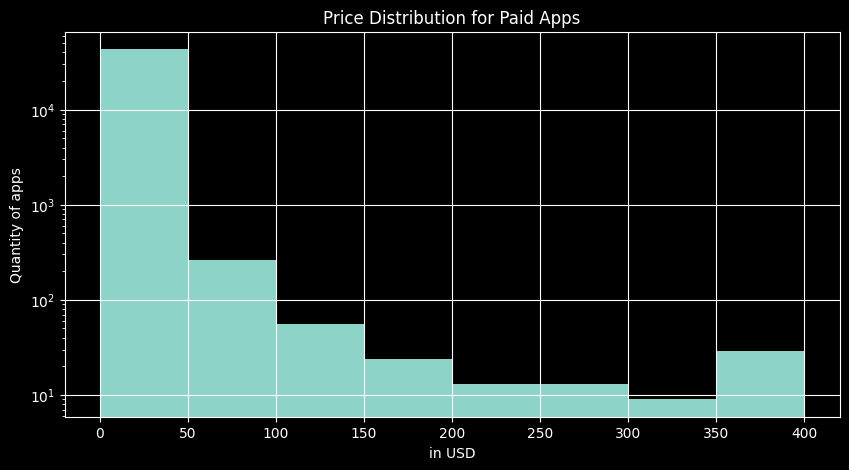

In [16]:
PlayStore.loc[~PlayStore['Free'],'Price'].hist(log=True, bins=8, figsize=(10,5))
plt.title('Price Distribution for Paid Apps')
plt.xlabel('in USD')
plt.ylabel('Quantity of apps')

In [17]:
PlayStore.loc[PlayStore['Price']>0, "App Id"].count() #43690 paid apps

43690

By definition we can say that most paid applications are outliers, because account for 1.9% of all apps

<AxesSubplot:>

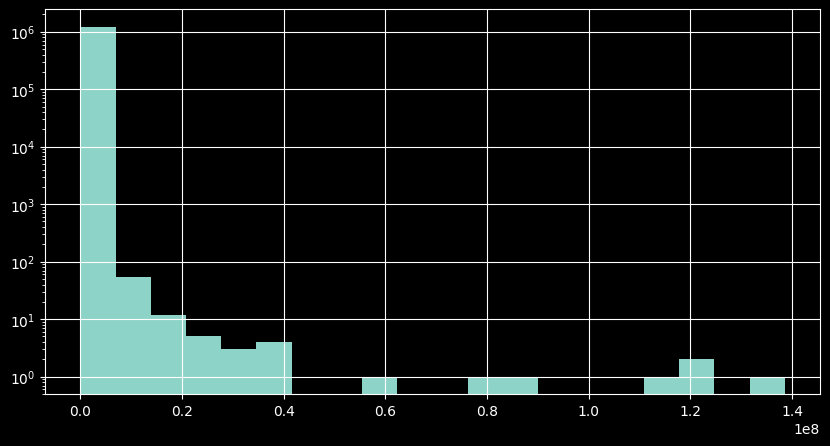

In [18]:
PlayStore.loc[PlayStore['Rating Count']>0, 'Rating Count'].hist(log=True, bins=20, figsize=(10,5))

It seems that there are many outliers in this dataset - there are countable number of apps with more than 0.2*10^8 counts

Let's look at dataset with less than 20_000_000

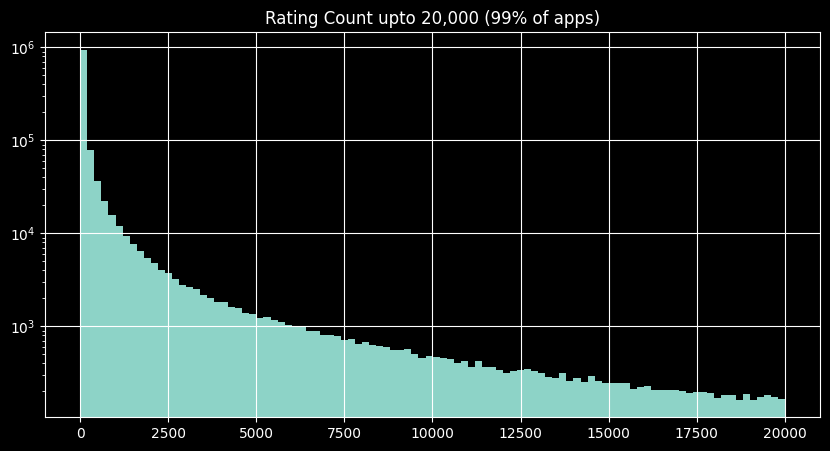

In [19]:
PlayStore.loc[(PlayStore['Rating Count'] <= 20_000) & (PlayStore['Rating Count'] > 0), 'Rating Count'].hist(log=True, bins=100, figsize=(10,5))
# the range (<= 20,000) holds 99% of apps
plt.title('Rating Count upto 20,000 (99% of apps)')
plt.show()

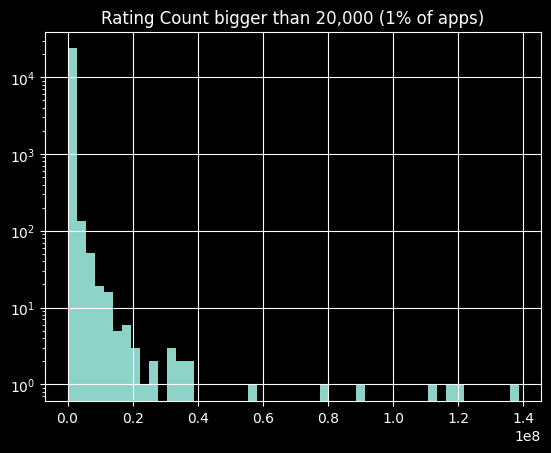

In [20]:
PlayStore.loc[PlayStore['Rating Count'] > 20_000, 'Rating Count'].hist(log=True, bins=50)
plt.title('Rating Count bigger than 20,000 (1% of apps)')
plt.show()

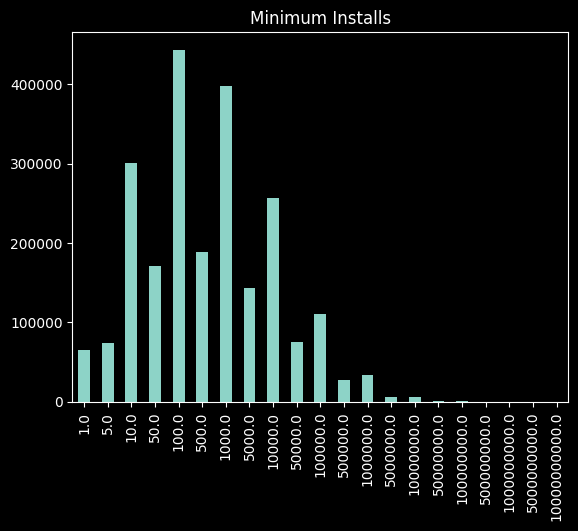

In [21]:
installs = PlayStore['Minimum Installs'].value_counts().sort_index()
installs.plot(kind='bar',logy=False)
plt.title('Minimum Installs')
plt.show()

We have outliers in case of big number of installs, we will investigate what are those outliers

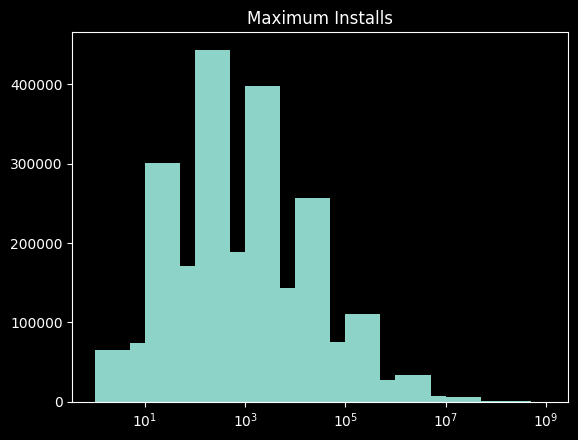

In [22]:
# PlayStore['Maximum Installs'].hist(log=True, bins=[0,1,5,10,50,100,500,1_000,5_000,10_000,50_000,100_000,500_000,1_000_000, 5_000_000,10_000_000,50_000_000,100_000_000,500_000_000,1_000_000_000])
fig, ax = plt.subplots()
ax.hist(PlayStore['Maximum Installs'], log=False, bins=[0,1,5,10,50,100,500,1_000,5_000,10_000,50_000,100_000,500_000,1_000_000, 5_000_000,10_000_000,50_000_000,100_000_000,500_000_000,1_000_000_000])
ax.set_xscale('log', base=10)
plt.title('Maximum Installs')
plt.show()

In [23]:
PlayStore.loc[PlayStore['Maximum Installs'] > 2_500_000, 'App Id'].count() / PlayStore['App Id'].count()
# one percent of all apps have more than 2.5 million installs

0.01087142140173941

Text(0.5, 1.0, 'Price Frequency')

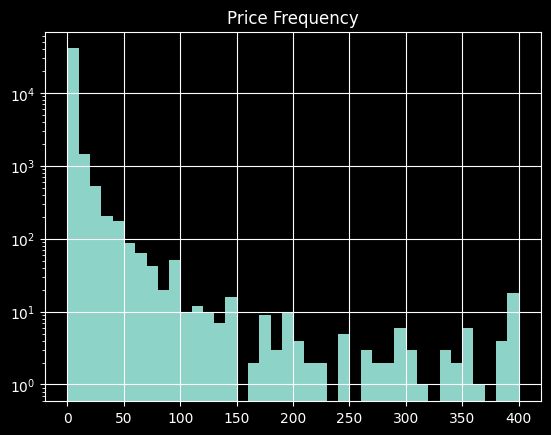

In [24]:
PlayStore.loc[PlayStore['Price'] > 0, 'Price'].hist(log=True, bins=40)
plt.title('Price Frequency')

In [25]:
PlayStore.loc[PlayStore['Price']>50, 'Price'].count() / PlayStore.loc[PlayStore['Price']>0, 'Price'].count() * 100
# Price that is less than 50$ holds 99% of all paid apps

0.933852140077821

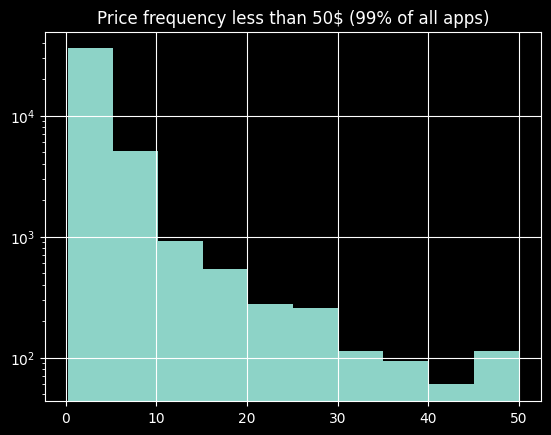

In [26]:
PlayStore.loc[(PlayStore['Price'] <= 50) & (PlayStore['Price'] > 0), 'Price'].hist(log=True, bins=10)
plt.title('Price frequency less than 50$ (99% of all apps)')
plt.show()

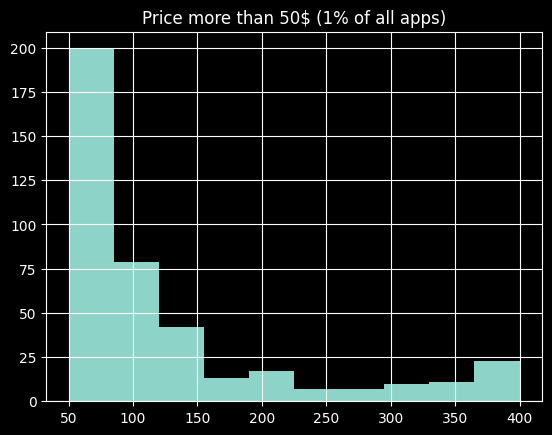

In [27]:
PlayStore.loc[(PlayStore['Price'] > 50), 'Price'].hist(log=False, bins=10)
plt.title('Price more than 50$ (1% of all apps)')
plt.show()

## AppStore

In [28]:
AppStore.describe()

,Size_Bytes,Price,DeveloperId,Average_User_Rating,Reviews,Size_Megabytes
count,"1,230,152.0000","1,230,376.0000","1,230,376.0000","1,230,376.0000","1,230,376.0000","1,230,152.0000"
mean,"75,108,571.0526",0.5039,"1,092,869,226.6780",1.7884,825.9478,75.1086
std,"231,872,643.7154",6.8683,"409,089,732.9217",2.1541,"50,160.5129",231.8726
min,"27,628.0000",0.0000,"281,656,478.0000",0.0000,0.0000,0.0276
25%,"20,413,440.0000",0.0000,"738,110,920.7500",0.0000,0.0000,20.4134
50%,"43,331,584.0000",0.0000,"1,179,711,165.0000",0.0000,0.0000,43.3316
75%,"83,654,656.0000",0.0000,"1,471,959,980.7500",4.3333,3.0000,83.6547
max,"76,779,452,340.0000",999.9900,"1,590,232,711.0000",5.0000,"22,685,334.0000","76,779.4523"


In [29]:
AppStore.loc[(AppStore['Average_User_Rating']>0), ['Price','Size_Megabytes', 'Average_User_Rating', 'Reviews']].describe()

,Price,Size_Megabytes,Average_User_Rating,Reviews
count,"546,056.0000","545,917.0000","546,056.0000","546,056.0000"
mean,0.4342,86.8825,4.0296,"1,861.0295"
std,4.6883,155.3850,1.1933,"75,281.5804"
min,0.0000,0.0276,1.0000,1.0000
25%,0.0000,23.2786,3.4762,1.0000
50%,0.0000,48.9482,4.5119,4.0000
75%,0.0000,97.7070,5.0000,19.0000
max,999.9900,"4,311.7906",5.0000,"22,685,334.0000"


In [30]:
AppStore[['Price','Size_Megabytes', 'Average_User_Rating', 'Reviews']].describe()

,Price,Size_Megabytes,Average_User_Rating,Reviews
count,"1,230,376.0000","1,230,152.0000","1,230,376.0000","1,230,376.0000"
mean,0.5039,75.1086,1.7884,825.9478
std,6.8683,231.8726,2.1541,"50,160.5129"
min,0.0000,0.0276,0.0000,0.0000
25%,0.0000,20.4134,0.0000,0.0000
50%,0.0000,43.3316,0.0000,0.0000
75%,0.0000,83.6547,4.3333,3.0000
max,999.9900,"76,779.4523",5.0000,"22,685,334.0000"


Text(0, 0.5, 'Number of apps')

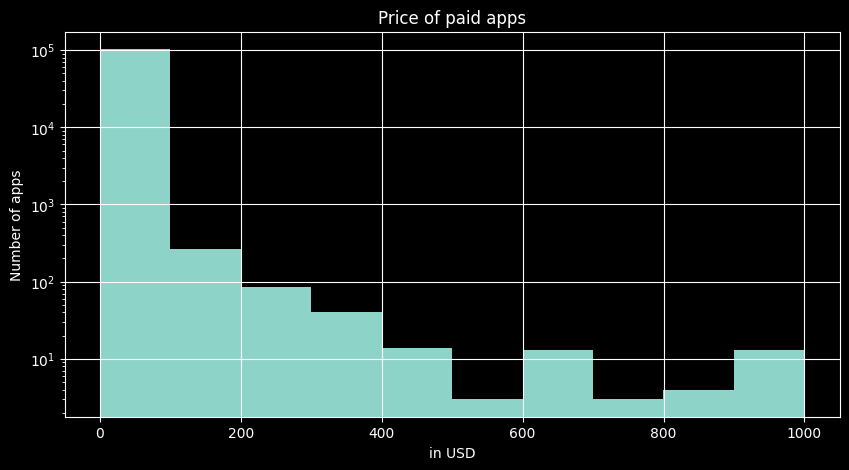

In [31]:
AppStore.loc[~AppStore['Free'],'Price'].hist(log=True, figsize=(10,5))
plt.title('Price of paid apps')
plt.xlabel('in USD')
plt.ylabel('Number of apps')

In [32]:
AppStore.loc[AppStore['Price']>50, 'Price'].count() / AppStore.loc[AppStore['Price']>0,'Price'].count()
# 99% of apps has price less than 50 USD

0.011970498136621724

In [33]:
AppStore.describe()

,Size_Bytes,Price,DeveloperId,Average_User_Rating,Reviews,Size_Megabytes
count,"1,230,152.0000","1,230,376.0000","1,230,376.0000","1,230,376.0000","1,230,376.0000","1,230,152.0000"
mean,"75,108,571.0526",0.5039,"1,092,869,226.6780",1.7884,825.9478,75.1086
std,"231,872,643.7154",6.8683,"409,089,732.9217",2.1541,"50,160.5129",231.8726
min,"27,628.0000",0.0000,"281,656,478.0000",0.0000,0.0000,0.0276
25%,"20,413,440.0000",0.0000,"738,110,920.7500",0.0000,0.0000,20.4134
50%,"43,331,584.0000",0.0000,"1,179,711,165.0000",0.0000,0.0000,43.3316
75%,"83,654,656.0000",0.0000,"1,471,959,980.7500",4.3333,3.0000,83.6547
max,"76,779,452,340.0000",999.9900,"1,590,232,711.0000",5.0000,"22,685,334.0000","76,779.4523"


Different methods of binning:

Text(0, 0.5, 'Number of apps')

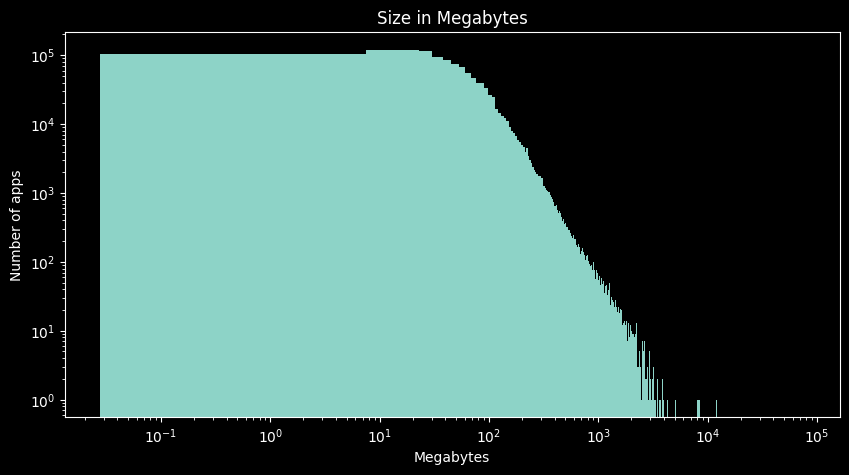

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(AppStore['Size_Megabytes'], bins='scott')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_title('Size in Megabytes')
ax.set_xlabel('Megabytes')
ax.set_ylabel('Number of apps')

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\histograms.py:793: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, uniform_bins = _get_bin_edges(a, bins, range, weights)


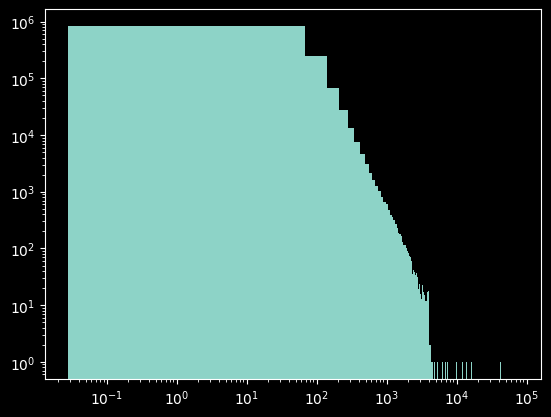

In [35]:
fig, ax = plt.subplots()
ax.hist(AppStore['Size_Megabytes'], bins='stone')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

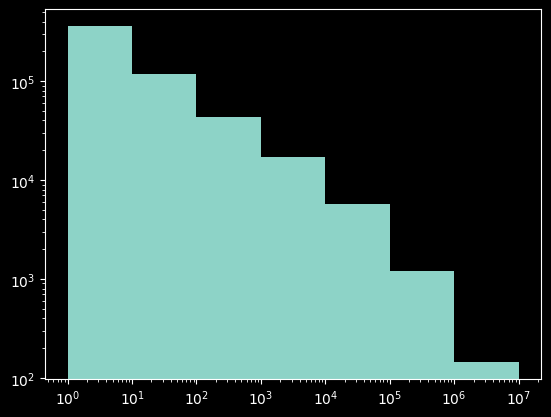

In [36]:
fig, ax = plt.subplots()
ax.hist(AppStore.loc[(AppStore['Reviews']>0) & (AppStore['Reviews']<10**9), 'Reviews'], bins=numpy.logspace(start=0, stop=7, num=8))
ax.set_yscale('log', base=10)
ax.set_xscale('log', base=10)

## Tranformation after the Cleaning

Many of the columns and their values have many extreme numbers, thus all of them will be transformed into log()

In [37]:
PlayStore['Rating Count log'] = PlayStore['Rating Count'].apply(lambda x: None if x==0 else numpy.log(x))
PlayStore['Maximum Installs log'] = PlayStore['Maximum Installs'].apply(lambda x: numpy.log(x))
PlayStore['Minimum Installs log'] = PlayStore['Minimum Installs'].apply(lambda x: numpy.log(x))
PlayStore['Size in kilobytes log'] = PlayStore['Size in kilobytes'].apply(lambda x: numpy.log(x))

In [38]:
AppStore['Size_Bytes log'] = AppStore['Size_Bytes'].apply(lambda x: numpy.log(x))
AppStore['Size_Megabytes log'] = AppStore['Size_Megabytes'].apply(lambda x: numpy.log(x))
AppStore['Reviews log'] = AppStore['Reviews'].apply(lambda x: None if x==0 else numpy.log(x))

# Explanotary Data Analysis (EDA)

## PlayStore

Working with categories of apps is very useful, here are some distribution of the app categories

In [39]:
PlayStore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2301355 entries, 0 to 2312943
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   App Name               object        
 1   App Id                 object        
 2   Category               category      
 3   Rating                 float16       
 4   Rating Count           float32       
 5   Minimum Installs       float64       
 6   Maximum Installs       int64         
 7   Free                   bool          
 8   Price                  float16       
 9   Size                   object        
 10  Developer Id           object        
 11  Released               datetime64[ns]
 12  Last Updated           datetime64[ns]
 13  Content Rating         category      
 14  Ad Supported           bool          
 15  In App Purchases       bool          
 16  Editors Choice         bool          
 17  Scraped Time           datetime64[ns]
 18  Size in kilobytes     

In [40]:
PlayStore['Category'].value_counts().sort_index()

Action                      27504
Adventure                   23152
Arcade                      53557
Art & Design                18444
Auto & Vehicles             18218
Beauty                      11689
Board                       10559
Books & Reference          115726
Business                   142885
Card                         8164
Casino                       5071
Casual                      50558
Comics                       2855
Communication               47977
Dating                       6512
Education                  239599
Educational                 21244
Entertainment              137779
Events                      12797
Finance                     65294
Food & Drink                73064
Health & Fitness            82637
House & Home                14182
Libraries & Demo             5170
Lifestyle                  117569
Maps & Navigation           26524
Medical                     31917
Music                        4193
Music & Audio              154169
News & Magazin

In [41]:
game_categories = ['Action','Adventure','Arcade','Board','Card','Casino','Casual','Educational','Music','Puzzle','Racing','Role Playing','Simulation','Sports','Strategy', 'Trivia', 'Word']
def in_game_cat(cat):
    if cat in game_categories: return 'Game'
    else: return cat

# Creating better categories
PlayStore['Category_2'] = PlayStore['Category'].apply(in_game_cat)
PlayStore['Category_2'].value_counts()

Game                       374845
Education                  239599
Music & Audio              154169
Tools                      143467
Business                   142885
Entertainment              137779
Lifestyle                  117569
Books & Reference          115726
Personalization             88982
Health & Fitness            82637
Productivity                79359
Shopping                    74857
Food & Drink                73064
Travel & Local              67043
Finance                     65294
Communication               47977
Social                      44587
News & Magazines            42727
Photography                 35481
Medical                     31917
Maps & Navigation           26524
Art & Design                18444
Auto & Vehicles             18218
House & Home                14182
Video Players & Editors     13997
Events                      12797
Beauty                      11689
Weather                      7207
Dating                       6512
Libraries & De

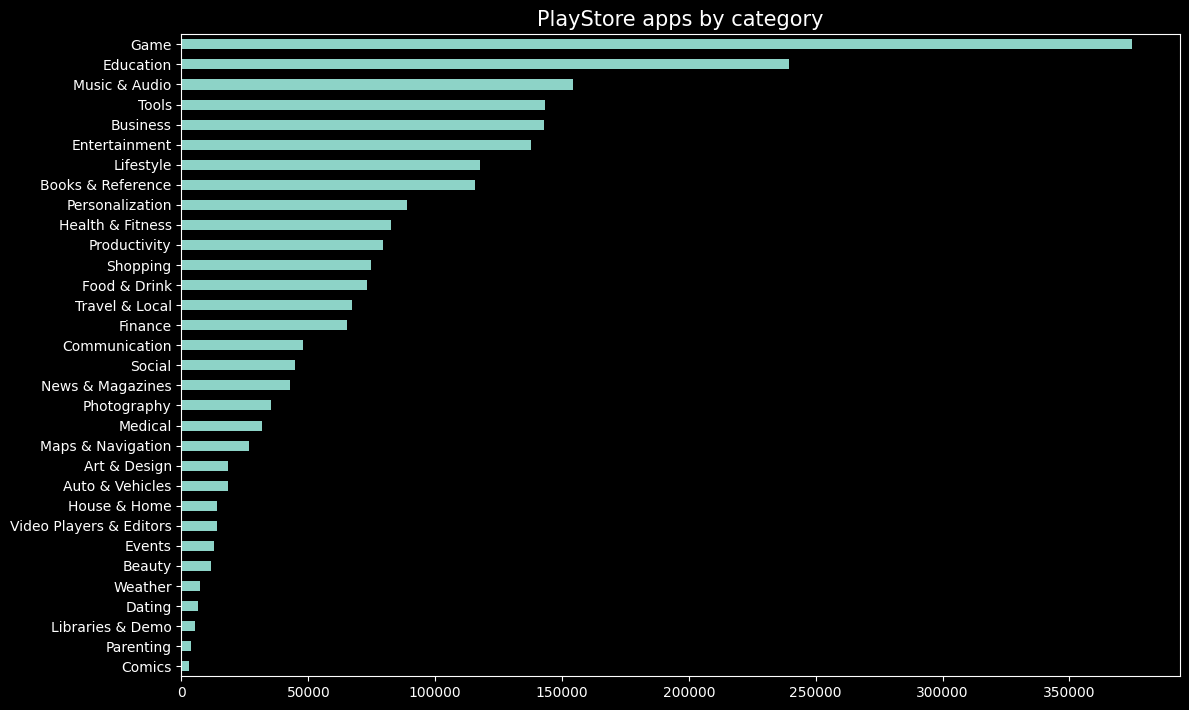

In [42]:
PlayStore['Category_2'].value_counts().iloc[::-1] .plot(kind='barh', figsize=(12,9))
plt.title(label='PlayStore apps by category', fontdict={'fontsize':15}, loc='center')
plt.tight_layout(rect=[0, 0.1, 1, 0.9])

In [43]:
# Pareto analysis
cat = PlayStore['Category_2'].value_counts(normalize=True).to_list()
sum = [0]
for x in cat:
    sum.append(sum[-1]+x)
sum
# 14th index is the break point

[0,
 0.1628801293151209,
 0.26699227194413727,
 0.33398280578181117,
 0.39632303577674893,
 0.45841037128126694,
 0.5182790138852981,
 0.5693658735831717,
 0.6196519007280494,
 0.6583169480588611,
 0.6942249240121582,
 0.7287085217187267,
 0.7612358806007766,
 0.7929841332606227,
 0.8221161011664868,
 0.8504880820212442,
 0.8713353654694735,
 0.8907096036900002,
 0.9092756224050615,
 0.9246930612617351,
 0.9385618472595495,
 0.9500872312181304,
 0.9581016401207118,
 0.9660178460081129,
 0.9721803024739776,
 0.9782623715159116,
 0.9838230086188356,
 0.9889021902314074,
 0.9920338235517773,
 0.9948634608741374,
 0.997109963478038,
 0.9987594265117725,
 1.0]

In [44]:
del cat, sum

Text(0.5, 1.0, 'Content Rating Categories')

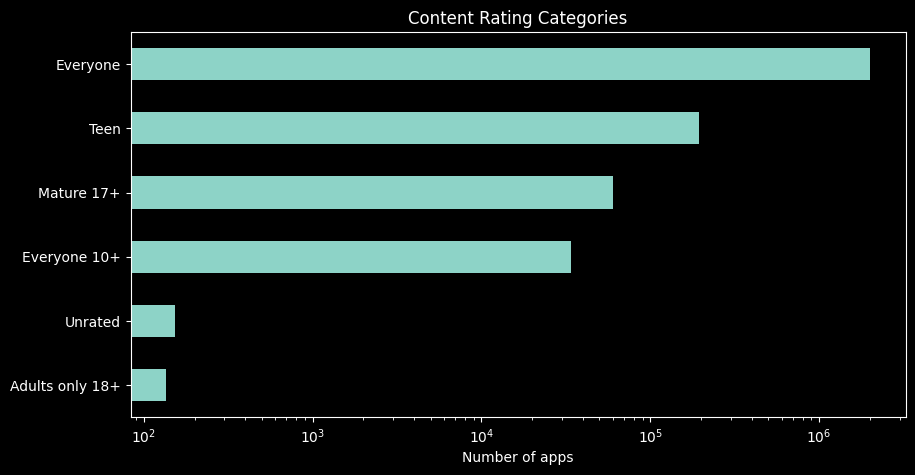

In [45]:
PlayStore['Content Rating'].value_counts().sort_values(ascending=True).plot(kind='barh', logx=True, figsize=(10,5))
plt.xlabel('Number of apps')
plt.title('Content Rating Categories')

Text(0.5, 1.0, 'Apps by Release date')

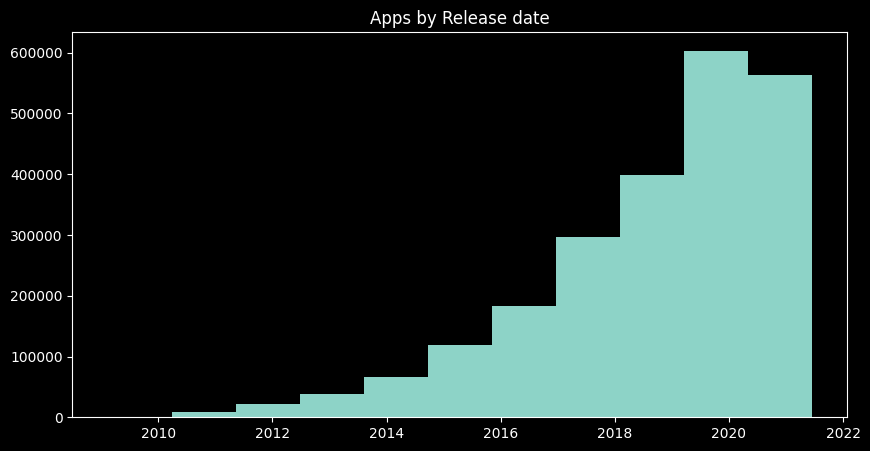

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(x=PlayStore['Released'], bins=11)
ax.set_title('Apps by Release date')

Text(0.5, 1.0, 'Apps by Update date')

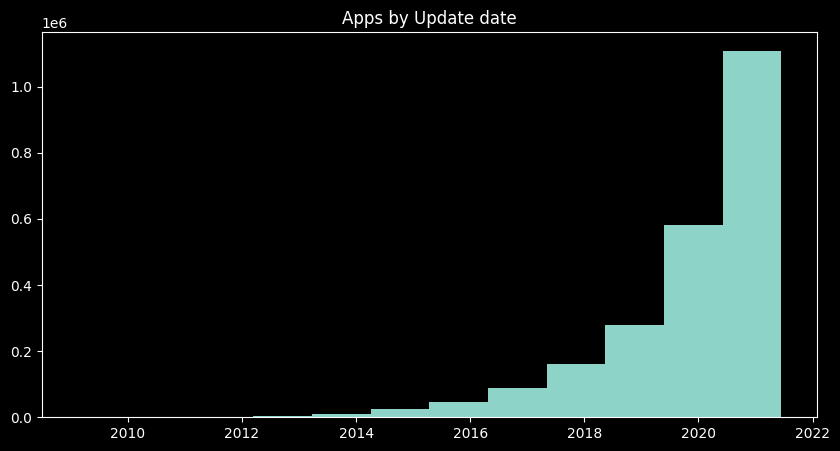

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(x=PlayStore['Last Updated'], bins=12)
ax.set_title('Apps by Update date')

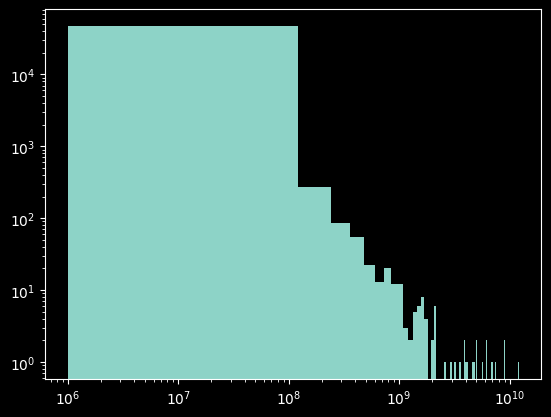

In [48]:
fig, ax = plt.subplots()
ax.hist(PlayStore.loc[PlayStore['Maximum Installs']>1_000_000, 'Maximum Installs'], bins=100, log=True)
#ax.hist(PlayStore.loc[PlayStore['Maximum Installs']>1_000_000, 'Maximum Installs'], bins=[10**6, 5*10**6, 10**7, 5*10**7, 10**8, 5*10**8, 10**9], log=True)
ax.set_xscale('log', base=10)
plt.show()

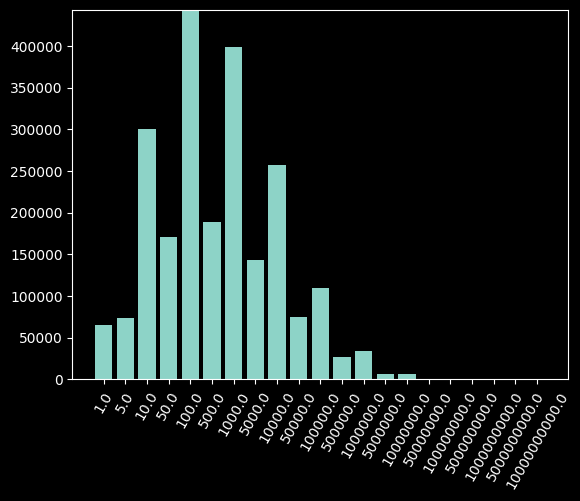

In [49]:
min_installs = PlayStore['Minimum Installs'].value_counts().sort_index().reset_index()
min_installs['index'] = min_installs['index'].astype('string')
plt.clf()
plt.bar(x=min_installs['index'], height=min_installs['Minimum Installs'])
plt.xticks(rotation=60)
plt.ylim(0, min_installs['Minimum Installs'].max())
plt.show()

(0.0, 1600.0)

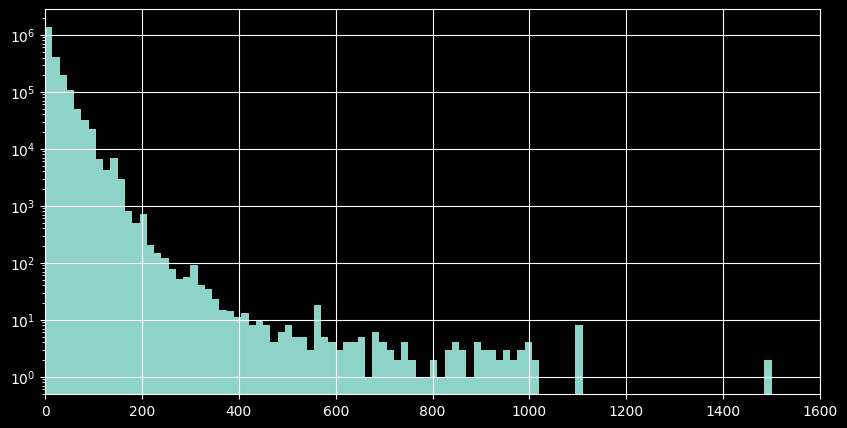

In [51]:
PlayStore['Size in kilobytes'].apply(lambda x: x/1000).hist(bins=100, log=True, figsize=(10,5))
plt.xlim(0,1600)

In [52]:
rating_mean = numpy.mean(PlayStore['Rating'].to_numpy(dtype='float64'))
rating_median = numpy.median(PlayStore['Rating'].to_numpy(dtype='float64'))
rating_std = numpy.std(PlayStore['Rating'].to_numpy(dtype='float64'))
print('All Apps rating mean = '+ str(rating_mean))
print('All Apps rating median = '+ str(rating_median))
print('All Apps rating StDev = '+ str(rating_std))

rating_mean = numpy.mean(PlayStore.loc[PlayStore['Rating']>0, 'Rating'].to_numpy(dtype='float64'))
rating_median = numpy.median(PlayStore.loc[PlayStore['Rating']>0, 'Rating'].to_numpy(dtype='float64'))
rating_std = numpy.std(PlayStore.loc[PlayStore['Rating']>0, 'Rating'].to_numpy(dtype='float64'))
print('Rated apps mean = '+ str(rating_mean))
print('Rated apps median = '+ str(rating_median))
print('Rated apps StDev = '+ str(rating_std))

del rating_mean, rating_median, rating_std

All Apps rating mean = 2.1921129905669705
All Apps rating median = 2.900390625
All Apps rating StDev = 2.1067066978720934
Rated apps mean = 4.100967837742734
Rated apps median = 4.19921875
Rated apps StDev = 0.6890439374849888


Text(0.5, 1.0, 'Rating Frequency Table for Rated apps')

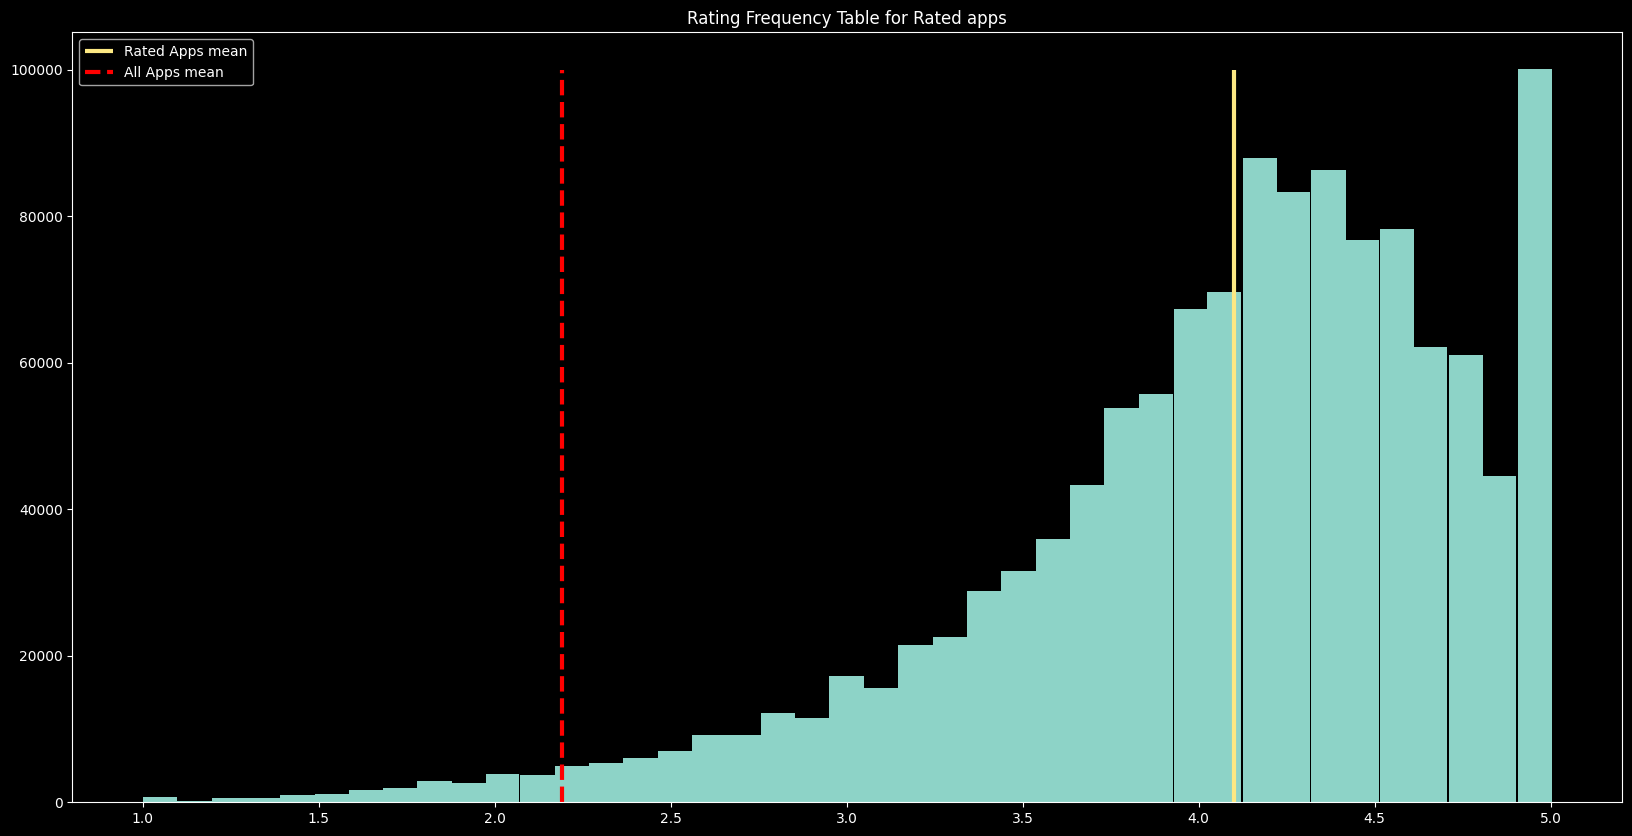

In [53]:
PlayStore.loc[PlayStore['Rating']>0, 'Rating'].hist(bins=41, figsize=(20,10), grid=False, align='mid', )
plt.vlines(numpy.mean(PlayStore.loc[PlayStore['Rating']>0, 'Rating'].to_numpy(dtype='float64')), ymin=0, ymax=100_000, label='Rated Apps mean', colors='#FCE883', linewidths=3)
plt.vlines(numpy.mean(PlayStore['Rating'].to_numpy(dtype='float64')), ymin=0, ymax=100_000, label='All Apps mean', colors='red', linewidths=3, linestyles='dashed')
plt.legend()
plt.title('Rating Frequency Table for Rated apps')

In [55]:
size_mean = numpy.mean(PlayStore.loc[~PlayStore['Size in kilobytes'].isna(), 'Size in kilobytes'].to_numpy(dtype='float64'))
size_std = numpy.std(PlayStore.loc[~PlayStore['Size in kilobytes'].isna(), 'Size in kilobytes'].to_numpy(dtype='float64'))
size_median = numpy.median(PlayStore.loc[~PlayStore['Size in kilobytes'].isna(), 'Size in kilobytes'].to_numpy(dtype='float64'))

print(f'Mean = {size_mean}')
print(f'Median = {size_median}')
print(f'Std= {size_std}')

del size_mean, size_std, size_median

Mean = 19202.987132338083
Median = 10000.0
Std= 24015.859938237245


In [56]:
for i in range(0,101,10):
    print(numpy.percentile(PlayStore.loc[~PlayStore['Size in kilobytes'].isna(),'Size in kilobytes'], q=i))

3.2
2800.0
4200.0
5700.0
7700.0
10000.0
14000.0
21000.0
30000.0
47000.0
1500000.0


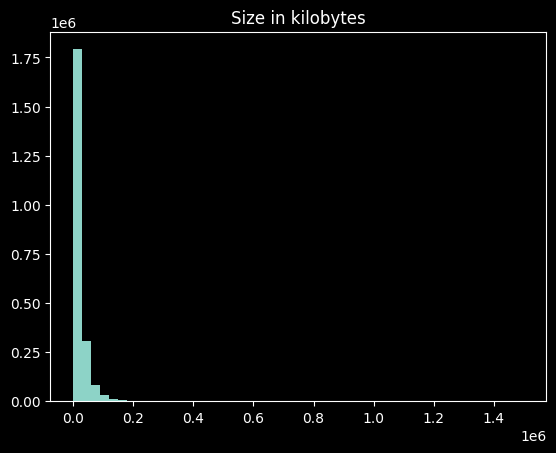

In [57]:
fig, ax = plt.subplots()
ax.hist(PlayStore['Size in kilobytes'], bins=50)
ax.set_title('Size in kilobytes')
plt.show()

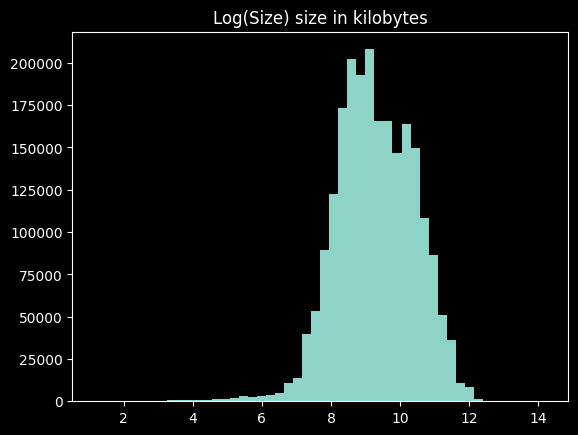

In [58]:
fig, ax = plt.subplots()
ax.hist(PlayStore['Size in kilobytes log'], bins=50)
ax.set_title('Log(Size) size in kilobytes')
plt.show()

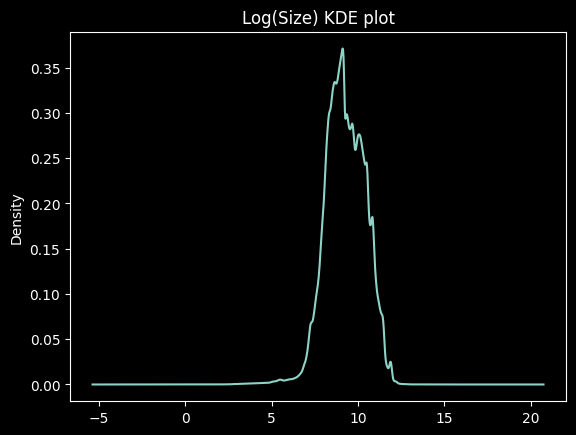

In [59]:
fig, ax = plt.subplots()
PlayStore['Size in kilobytes log'].plot.kde(ax=ax)
ax.set_title('Log(Size) KDE plot')
plt.show()

In [60]:
PlayStore['Free'].value_counts(normalize=True)[0]

0.018984467846116744

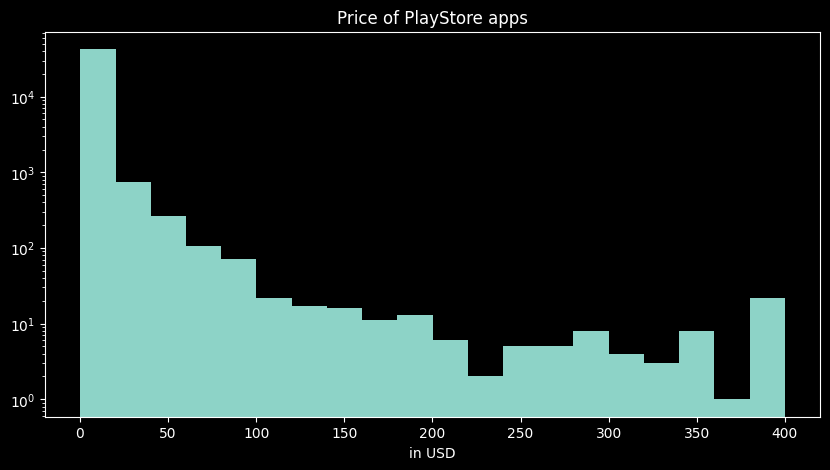

In [61]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(PlayStore.loc[~PlayStore['Free'],'Price'], bins=20)
ax.set_yscale('log', base=10)
ax.set_title('Price of PlayStore apps')
ax.set_xlabel('in USD')
plt.show()

In [62]:
PlayStore[['Rating', 'Rating Count',
       'Minimum Installs', 'Maximum Installs', 'Free', 'Price', 'Size',
       'Developer Id', 'Released', 'Last Updated', 'Content Rating',
       'Ad Supported', 'In App Purchases', 'Editors Choice', 'Scraped Time',
       'Size in kilobytes','Size in kilobytes log']].corr(method='spearman').style\
              .highlight_between(left=0.1, right=1, color='lightgreen')\
              .highlight_max(color='green')\
              .highlight_between(left=-1, right=-0.1, color='red') #.to_excel('corr_matrix.xlsx')

,Rating,Rating Count,Minimum Installs,Maximum Installs,Free,Price,Ad Supported,In App Purchases,Editors Choice,Size in kilobytes,Size in kilobytes log
Rating,1.000000,0.806404,0.586287,0.591931,-0.015008,0.015077,0.142225,0.129755,0.019354,0.051238,0.051238
Rating Count,0.806404,1.000000,0.834819,0.840942,-0.017705,0.017821,0.188512,0.221894,0.034615,0.086728,0.086728
Minimum Installs,0.586287,0.834819,1.000000,0.991290,0.043836,-0.043749,0.250115,0.216825,0.032799,0.064054,0.064054
Maximum Installs,0.591931,0.840942,0.991290,1.000000,0.043833,-0.043744,0.251616,0.217560,0.032588,0.063790,0.063790
Free,-0.015008,-0.017705,0.043836,0.043833,1.000000,-0.999940,0.122650,0.007757,-0.003276,0.015667,0.015667
Price,0.015077,0.017821,-0.043749,-0.043744,-0.999940,1.000000,-0.122645,-0.007738,0.003314,-0.015434,-0.015434
Ad Supported,0.142225,0.188512,0.250115,0.251616,0.122650,-0.122645,1.000000,0.138182,0.005680,-0.022923,-0.022923
In App Purchases,0.129755,0.221894,0.216825,0.217560,0.007757,-0.007738,0.138182,1.000000,0.046075,0.179513,0.179513
Editors Choice,0.019354,0.034615,0.032799,0.032588,-0.003276,0.003314,0.005680,0.046075,1.000000,0.024226,0.024226
Size in kilobytes,0.051238,0.086728,0.064054,0.063790,0.015667,-0.015434,-0.022923,0.179513,0.024226,1.000000,1.000000


In [63]:
PlayStore.describe()

,Rating,Rating Count,Minimum Installs,Maximum Installs,Price,Size in kilobytes,Rating Count log,Maximum Installs log,Minimum Installs log,Size in kilobytes log
count,"2,301,355.0000","2,301,355.0000","2,301,355.0000","2,301,355.0000","2,301,355.0000","2,226,706.0000","1,230,156.0000","2,301,355.0000","2,301,355.0000","2,226,706.0000"
mean,NaN,"2,850.7771","184,361.8492","321,814.1622",NaN,"19,202.9871",4.0954,6.8068,6.1552,9.2773
std,0.0000,"211,641.4219","15,169,133.7116","23,614,177.6316",NaN,"24,015.8653",2.1308,3.1696,3.1816,1.1368
min,0.0000,0.0000,1.0000,1.0000,0.0000,3.2000,1.6094,0.0000,0.0000,1.1632
25%,0.0000,0.0000,50.0000,87.0000,0.0000,"4,900.0000",2.4849,4.4659,3.9120,8.4970
50%,2.9004,6.0000,500.0000,710.0000,0.0000,"10,000.0000",3.5553,6.5653,6.2146,9.2103
75%,4.3008,41.0000,"5,000.0000","7,457.0000",0.0000,"25,000.0000",5.1818,8.9169,8.5172,10.1266
max,5.0000,"138,557,568.0000","10,000,000,000.0000","12,057,627,016.0000",400.0000,"1,500,000.0000",18.7468,23.2130,23.0259,14.2210


In [64]:
PlayStore.loc[PlayStore['Rating Count']>0].describe()

,Rating,Rating Count,Minimum Installs,Maximum Installs,Price,Size in kilobytes,Rating Count log,Maximum Installs log,Minimum Installs log,Size in kilobytes log
count,"1,230,156.0000","1,230,156.0000","1,230,156.0000","1,230,156.0000","1,230,156.0000","1,190,599.0000","1,230,156.0000","1,230,156.0000","1,230,156.0000","1,190,599.0000"
mean,NaN,"5,333.1875","344,065.2579","600,444.8958",NaN,"20,487.2295",4.0954,8.8679,8.2040,9.3334
std,0.0000,"289,453.0625","20,746,290.7661","32,294,657.8169",NaN,"25,384.3057",2.1308,2.5390,2.5771,1.1584
min,1.0000,5.0000,1.0000,1.0000,0.0000,3.2000,1.6094,0.0000,0.0000,1.1632
25%,3.8008,12.0000,"1,000.0000","1,268.0000",0.0000,"5,100.0000",2.4849,7.1452,6.9078,8.5370
50%,4.1992,35.0000,"5,000.0000","5,636.0000",0.0000,"11,000.0000",3.5553,8.6369,8.5172,9.3057
75%,4.6016,178.0000,"10,000.0000","33,505.0000",0.0000,"27,000.0000",5.1818,10.4194,9.2103,10.2036
max,5.0000,"138,557,568.0000","10,000,000,000.0000","12,057,627,016.0000",400.0000,"1,500,000.0000",18.7468,23.2130,23.0259,14.2210


## Analysis by category

In [65]:
PlayStore.groupby('Category_2').mean()[['Rating','Rating Count', 'Minimum Installs','Size in kilobytes']].sort_values('Minimum Installs', ascending=False)

,Rating,Rating Count,Minimum Installs,Size in kilobytes
Category_2,,,,
Video Players & Editors,2.8887,"18,930.6777","1,328,224.2058","23,136.0392"
Communication,2.1035,"9,797.9541","900,777.3465","16,690.2687"
Photography,2.5137,"6,004.4941","535,468.5314","17,163.9609"
Tools,2.3223,"3,295.3916","497,958.2167","10,943.0836"
Social,2.3691,"10,549.5479","385,000.1206","18,567.3171"
Weather,3.0859,"5,196.4258","384,889.8379","22,694.0879"
Productivity,1.9102,"1,893.8196","356,784.3991","15,055.8017"
Game,2.6035,"7,508.5005","316,989.7460","30,318.5775"
Travel & Local,1.9102,"1,094.0645","145,074.4081","20,375.1293"


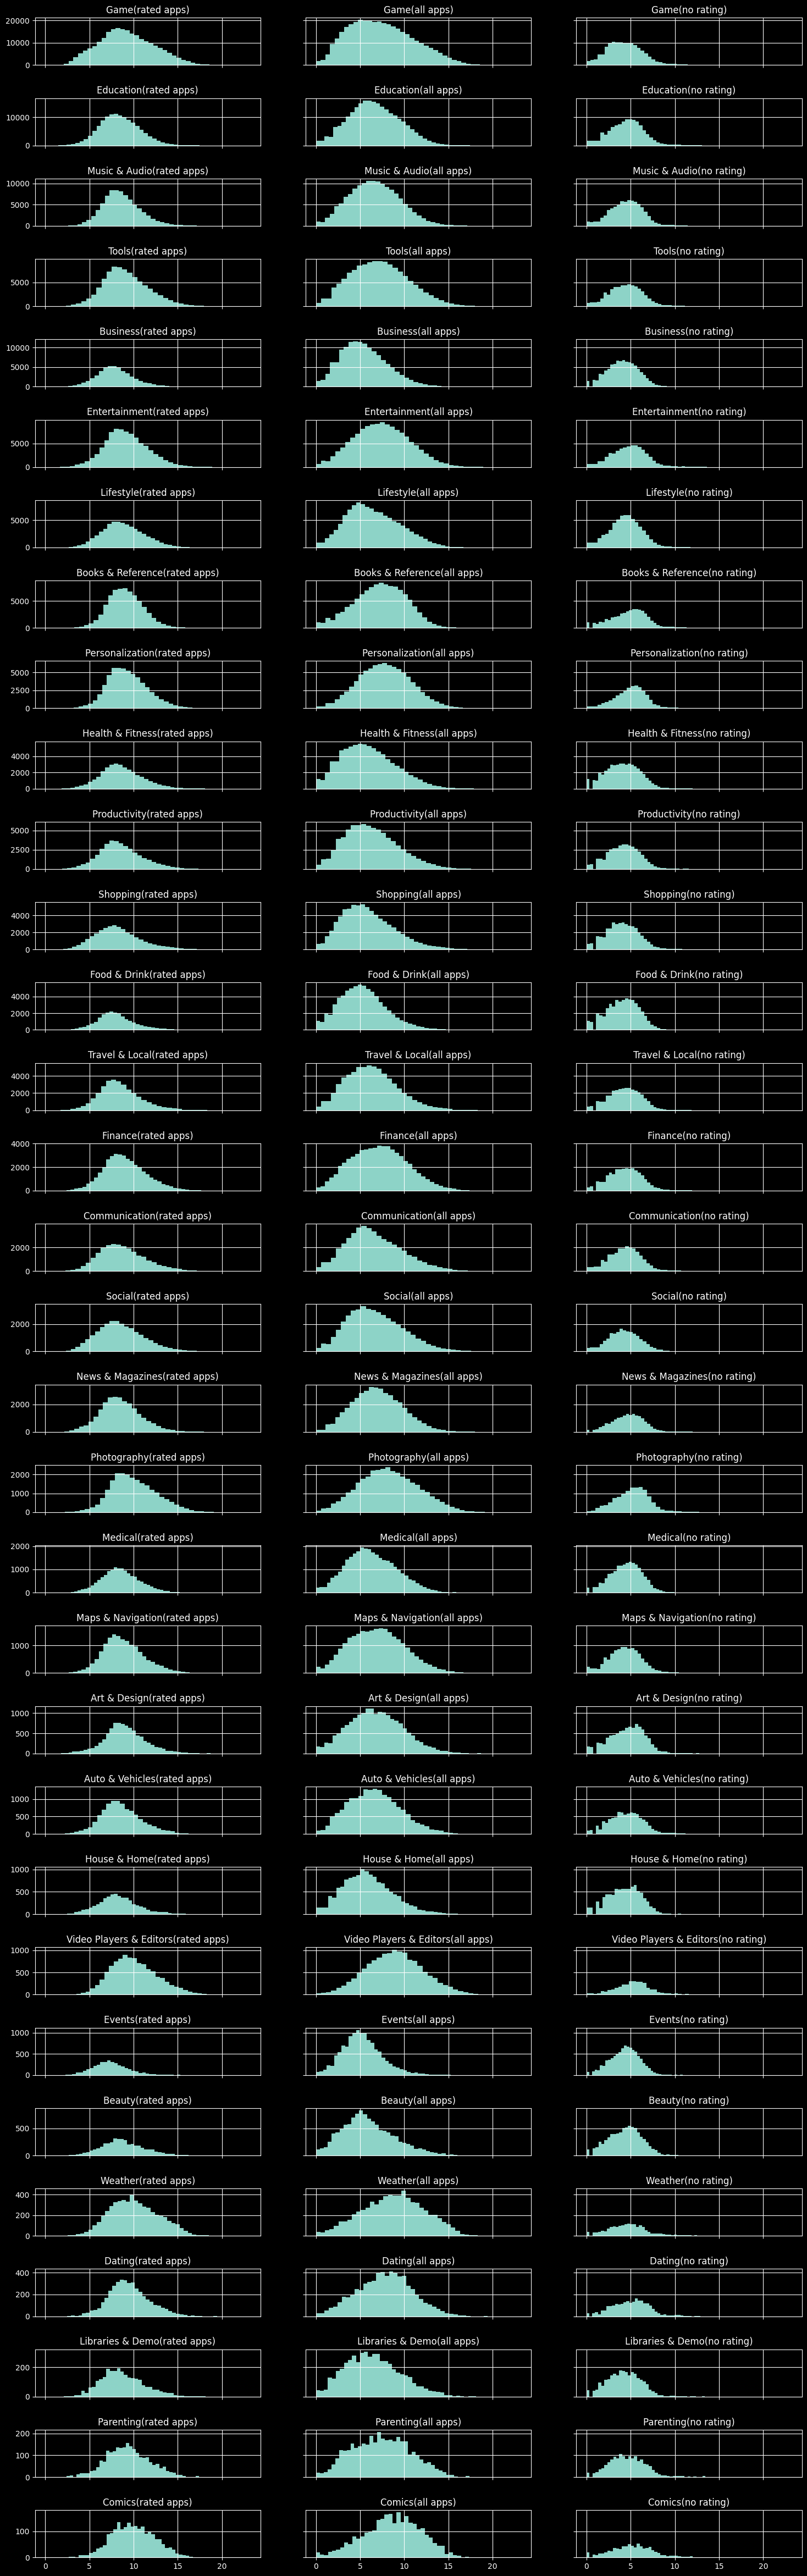

In [66]:
fig, ax = plt.subplots(nrows=32, ncols=3, figsize=(18,60), sharex=True, sharey='row')

fig.subplots_adjust(hspace=0.7)

counter = 0
for i in PlayStore['Category_2'].value_counts().index.to_list():
    PlayStore.loc[(PlayStore['Rating']>0) & (PlayStore['Category_2']==i), 'Maximum Installs log'].hist(ax=ax[counter,0], bins=40, label=i)
    PlayStore.loc[(PlayStore['Category_2']==i), 'Maximum Installs log'].hist(ax=ax[counter,1], bins=40, label=i)
    PlayStore.loc[(PlayStore['Rating']==0) & (PlayStore['Category_2']==i), 'Maximum Installs log'].hist(ax=ax[counter,2], bins=40, label=i)
    ax[counter,0].set_title(f'{i}(rated apps)')
    ax[counter,1].set_title(f'{i}(all apps)')
    ax[counter,2].set_title(f'{i}(no rating)')
    counter += 1

del counter
plt.show()

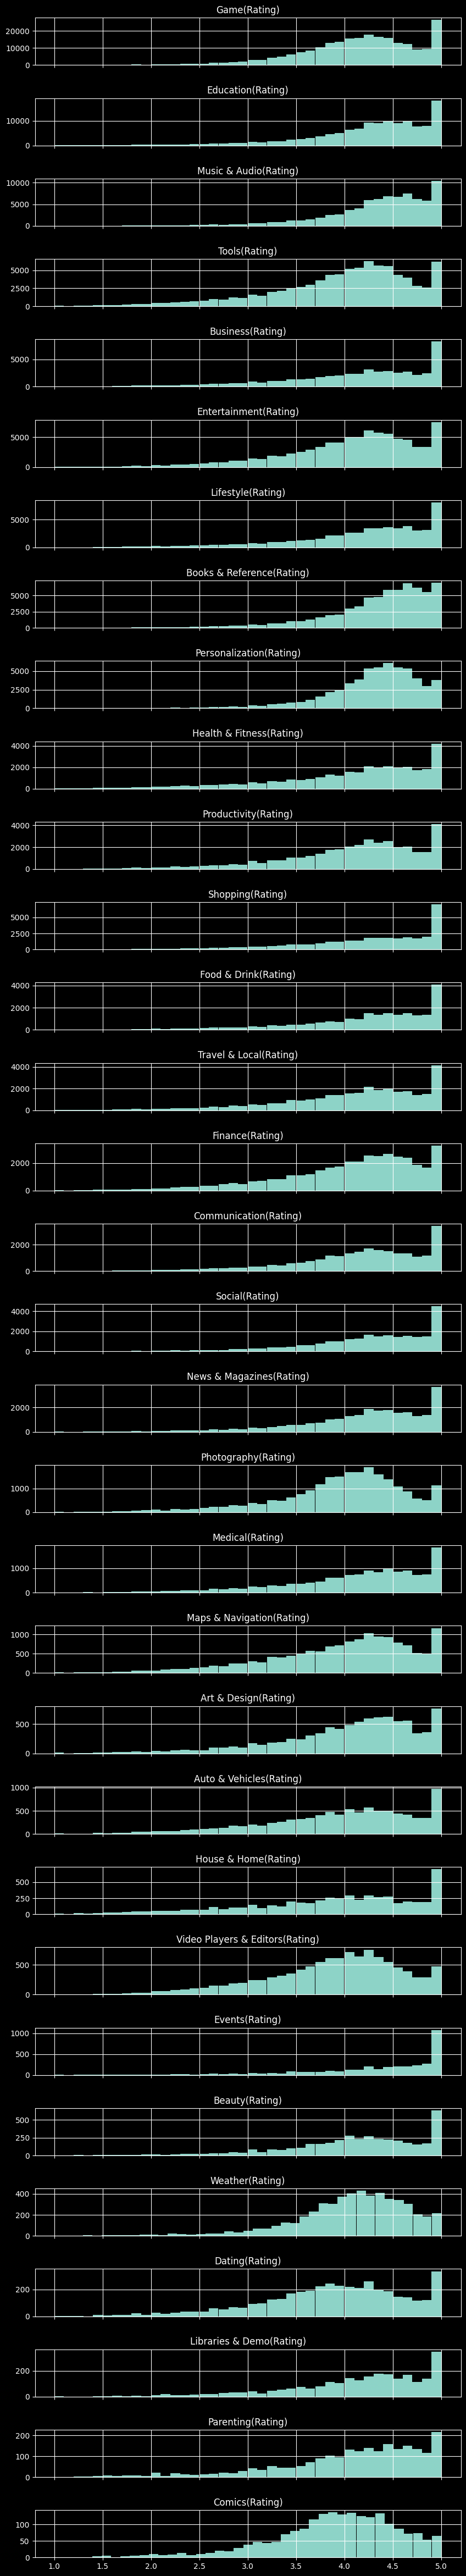

In [67]:
fig, ax = plt.subplots(nrows=32, ncols=1, figsize=(10,60), sharex=True, sharey='row')

fig.subplots_adjust(hspace=0.7)

counter = 0
for i in PlayStore['Category_2'].value_counts().index.to_list():
    PlayStore.loc[(PlayStore['Rating']>0) & (PlayStore['Category_2']==i), 'Rating'].hist(ax=ax[counter], bins=40, label=i)
    ax[counter].set_title(f'{i}(Rating)')
    counter += 1

del counter
plt.show()

<AxesSubplot:>

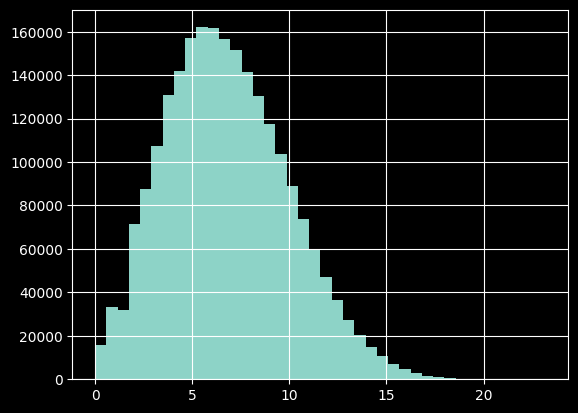

In [68]:
PlayStore['Maximum Installs log'].hist(bins=40)

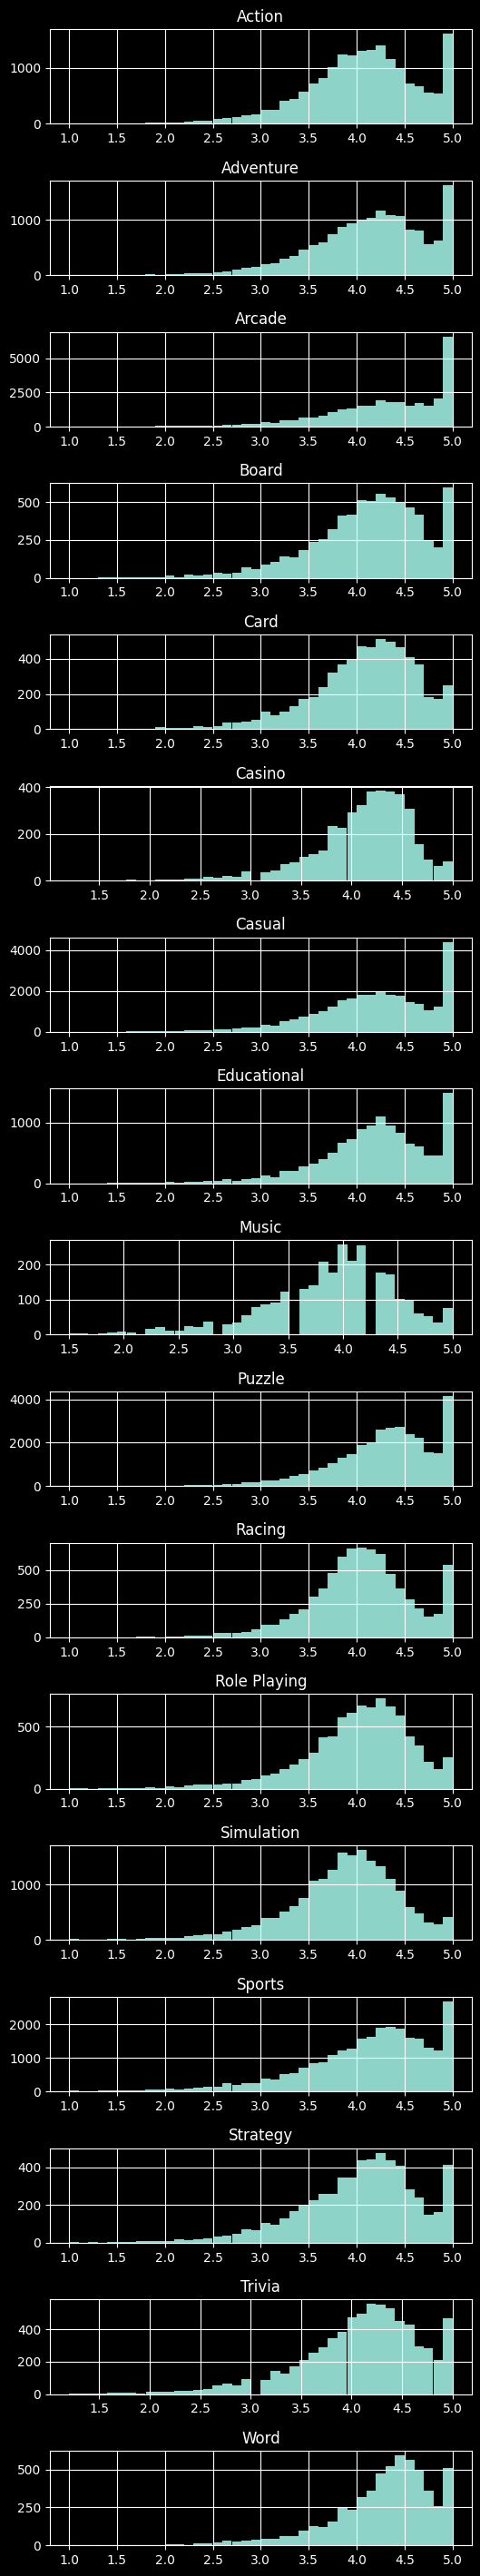

In [69]:
game_categories = ['Action','Adventure','Arcade','Board','Card','Casino','Casual','Educational','Music','Puzzle','Racing','Role Playing','Simulation','Sports','Strategy', 'Trivia', 'Word']

fig, ax = plt.subplots(17,1, figsize=(6,36))
fig.subplots_adjust(hspace=0.6)
counter = 0
for i in game_categories:
    PlayStore.loc[(PlayStore['Category']==i)&(PlayStore['Rating']>0), 'Rating'].hist(bins=40, ax=ax[counter], label=i)
    ax[counter].set_title(f'{i}')
    counter += 1

## AppStore

In [70]:
AppStore.describe()

,Size_Bytes,Price,DeveloperId,Average_User_Rating,Reviews,Size_Megabytes,Size_Bytes log,Size_Megabytes log,Reviews log
count,"1,230,152.0000","1,230,376.0000","1,230,376.0000","1,230,376.0000","1,230,376.0000","1,230,152.0000","1,230,152.0000","1,230,152.0000","546,056.0000"
mean,"75,108,571.0526",0.5039,"1,092,869,226.6780",1.7884,825.9478,75.1086,17.4734,3.6579,2.0258
std,"231,872,643.7154",6.8683,"409,089,732.9217",2.1541,"50,160.5129",231.8726,1.1930,1.1930,2.2077
min,"27,628.0000",0.0000,"281,656,478.0000",0.0000,0.0000,0.0276,10.2266,-3.5889,0.0000
25%,"20,413,440.0000",0.0000,"738,110,920.7500",0.0000,0.0000,20.4134,16.8317,3.0162,0.0000
50%,"43,331,584.0000",0.0000,"1,179,711,165.0000",0.0000,0.0000,43.3316,17.5844,3.7689,1.3863
75%,"83,654,656.0000",0.0000,"1,471,959,980.7500",4.3333,3.0000,83.6547,18.2422,4.4267,2.9444
max,"76,779,452,340.0000",999.9900,"1,590,232,711.0000",5.0000,"22,685,334.0000","76,779.4523",25.0642,11.2487,16.9372


In [71]:
AppStore.loc[AppStore['Price']<=50].describe()
# not significantly differs from full dataset

,Size_Bytes,Price,DeveloperId,Average_User_Rating,Reviews,Size_Megabytes,Size_Bytes log,Size_Megabytes log,Reviews log
count,"1,228,925.0000","1,229,149.0000","1,229,149.0000","1,229,149.0000","1,229,149.0000","1,228,925.0000","1,228,925.0000","1,228,925.0000","545,722.0000"
mean,"74,892,286.4146",0.3603,"1,093,207,747.3892",1.7891,826.7436,74.8923,17.4729,3.6574,2.0261
std,"228,401,522.1899",2.1534,"408,920,411.5414",2.1542,"50,185.5350",228.4015,1.1921,1.1921,2.2079
min,"27,628.0000",0.0000,"281,656,478.0000",0.0000,0.0000,0.0276,10.2266,-3.5889,0.0000
25%,"20,416,512.0000",0.0000,"739,095,842.0000",0.0000,0.0000,20.4165,16.8319,3.0163,0.0000
50%,"43,323,392.0000",0.0000,"1,179,966,105.0000",0.0000,0.0000,43.3234,17.5842,3.7687,1.3863
75%,"83,602,432.0000",0.0000,"1,472,052,485.0000",4.3333,3.0000,83.6024,18.2416,4.4261,2.9444
max,"76,779,452,340.0000",49.9900,"1,590,232,711.0000",5.0000,"22,685,334.0000","76,779.4523",25.0642,11.2487,16.9372


Text(0, 0.5, 'Number of apps')

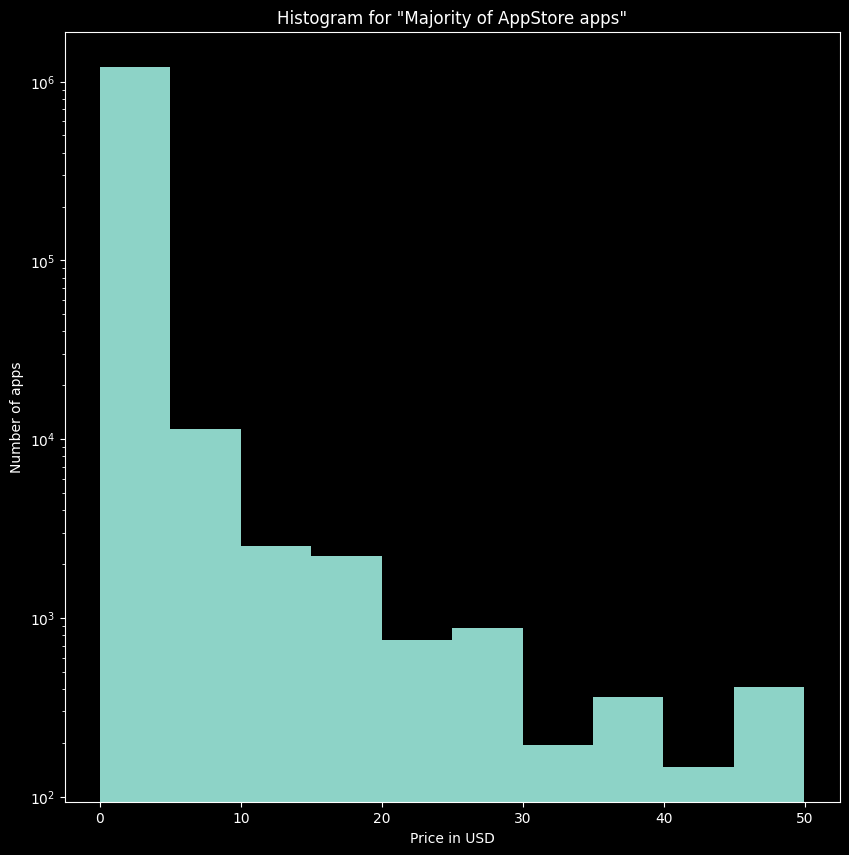

In [72]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(AppStore.loc[AppStore['Price']<=50, 'Price'], bins=10, log=True)
ax.set_title('Histogram for "Majority of AppStore apps"')
ax.set_xlabel('Price in USD')
ax.set_ylabel('Number of apps')

Text(0, 0.5, 'Number of apps')

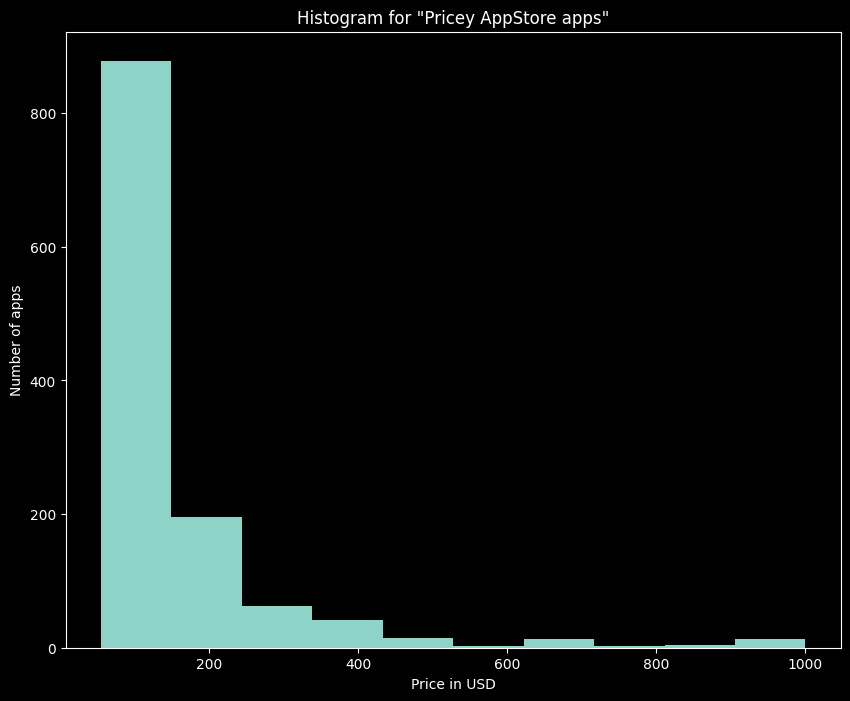

In [73]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(AppStore.loc[AppStore['Price']>50, 'Price'], bins=10)
ax.set_title('Histogram for "Pricey AppStore apps"')
ax.set_xlabel('Price in USD')
ax.set_ylabel('Number of apps')

In [74]:
AppStore.loc[AppStore['Average_User_Rating']>0, 'Average_User_Rating'].mean()

4.0296014218321945

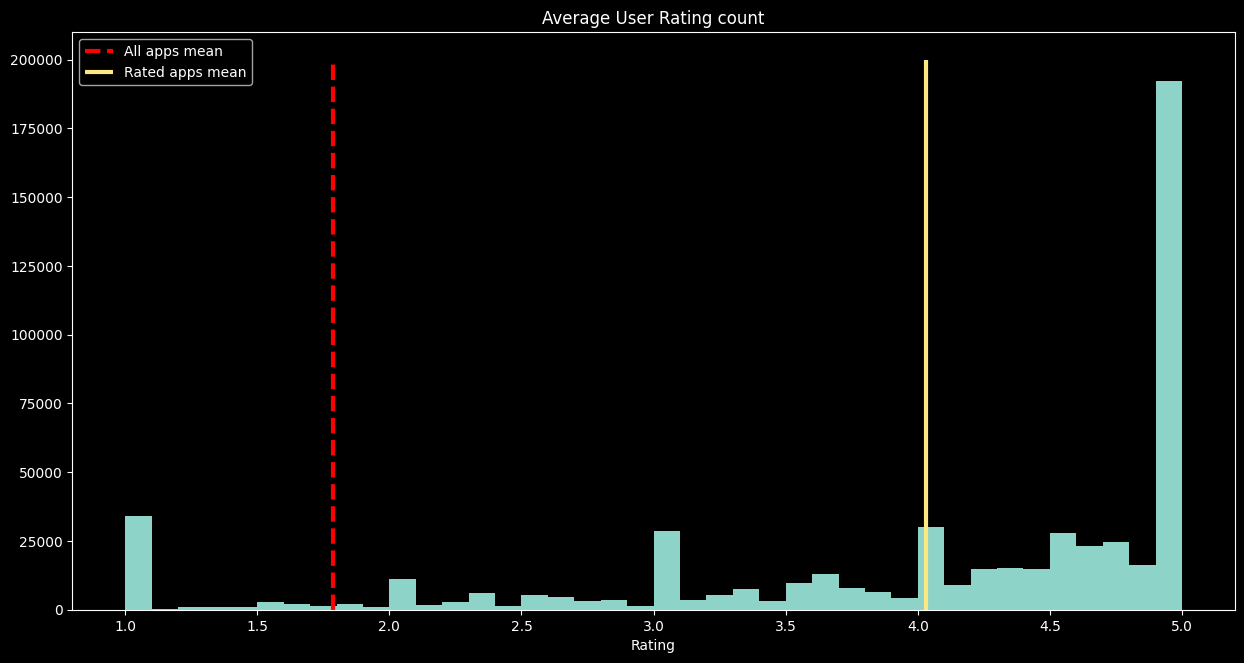

In [75]:
fig, ax = plt.subplots(figsize=(15,7.5))
ax.hist(AppStore.loc[AppStore['Average_User_Rating']>0, 'Average_User_Rating'], bins=40)
ax.set_title('Average User Rating count')
ax.set_xlabel('Rating')
ax.vlines(AppStore.loc[AppStore['Average_User_Rating']>=0, 'Average_User_Rating'].mean(), label='All apps mean', linestyles='dashed', linewidths=3, color='red', ymin=0, ymax=200_000)
ax.vlines(AppStore.loc[AppStore['Average_User_Rating']>0, 'Average_User_Rating'].mean(), label='Rated apps mean', linewidths=3, color='#FCE883', ymin=0, ymax=200_000)
plt.legend()

Text(0, 0.5, 'Apps count')

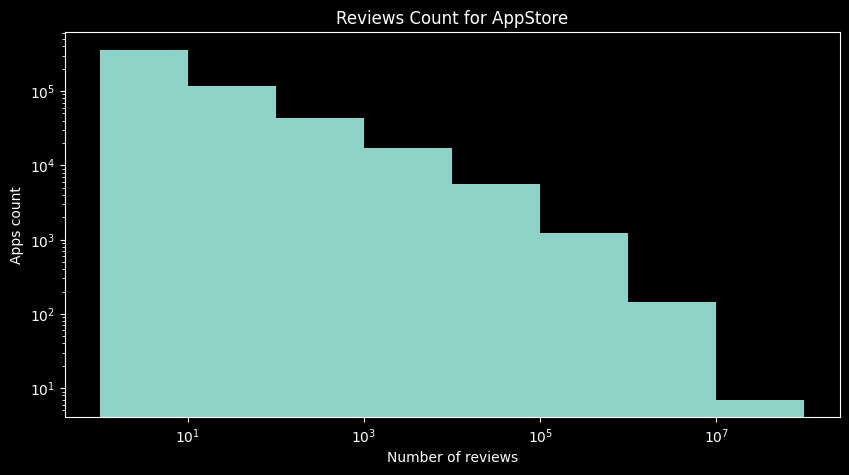

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(AppStore['Reviews'], bins=numpy.logspace(0,8, num=9))
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_title('Reviews Count for AppStore')
ax.set_xlabel('Number of reviews')
ax.set_ylabel('Apps count')

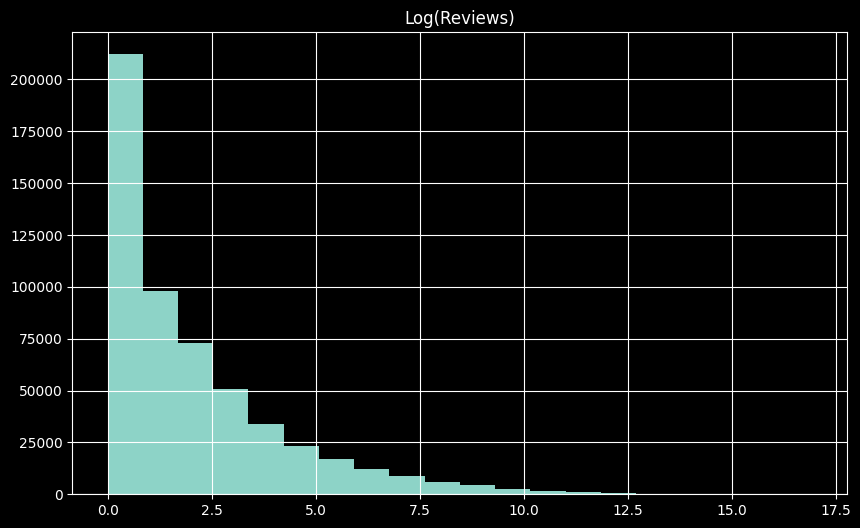

In [77]:
fig, ax = plt.subplots(figsize=(10,6))
AppStore.loc[AppStore['Reviews']>=0, 'Reviews log'].hist(bins=20, ax=ax)
ax.set_title('Log(Reviews)')
plt.show()

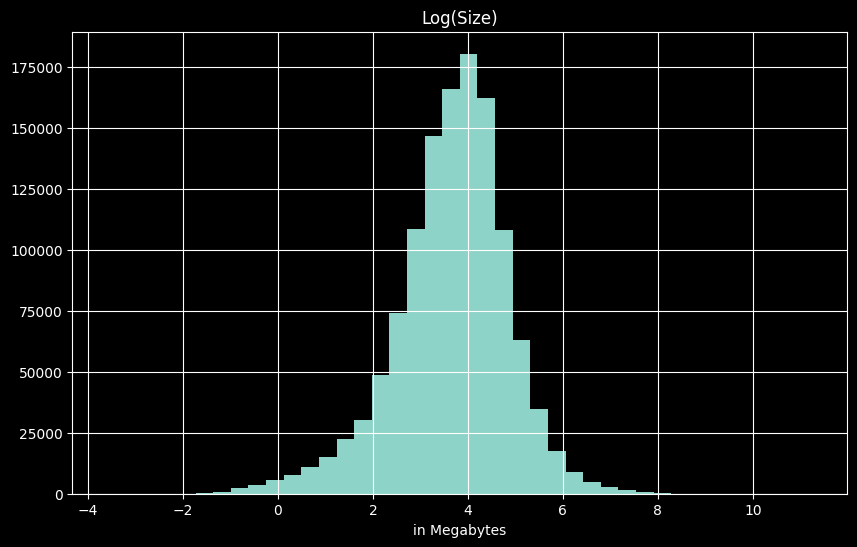

In [78]:
fig, ax = plt.subplots(figsize=(10,6))
AppStore['Size_Megabytes log'].hist(bins=40, ax=ax)
ax.set_title('Log(Size)')
ax.set_xlabel('in Megabytes')
plt.show()

## Analysis by category

In [79]:
AppStore.columns

Index(['App_Id', 'App_Name', 'AppStore_Url', 'Primary_Genre', 'Content_Rating',
       'Size_Bytes', 'Released', 'Updated', 'Price', 'Free', 'DeveloperId',
       'Developer', 'Average_User_Rating', 'Reviews', 'isMissingPrice',
       'Size_Megabytes', 'Size_Bytes log', 'Size_Megabytes log',
       'Reviews log'],
      dtype='object')

<AxesSubplot:title={'center':'Primary Genre'}>

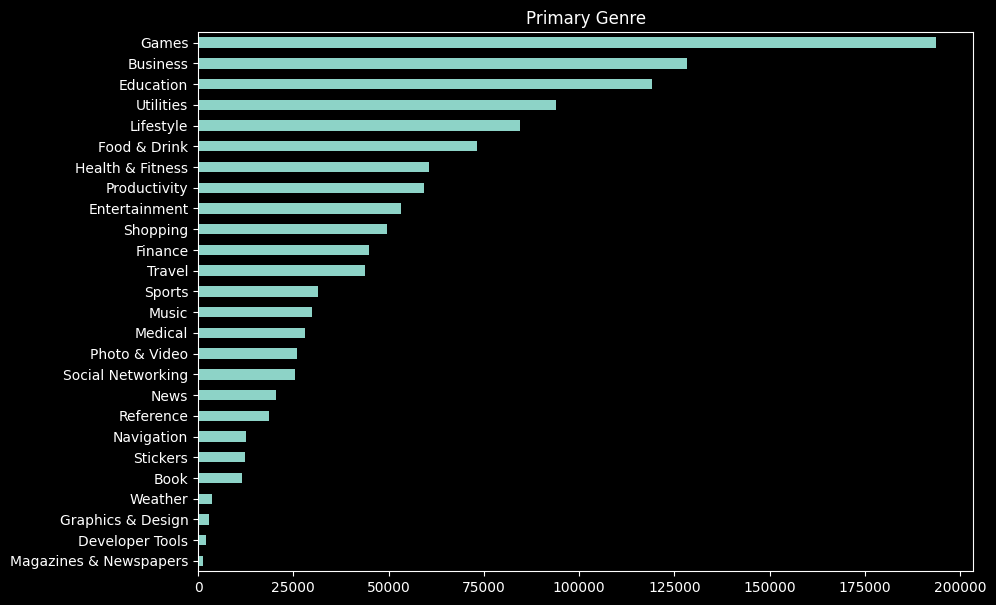

In [80]:
AppStore['Primary_Genre'].value_counts(ascending=True).plot.barh(figsize=(10,7), title='Primary Genre')

In [81]:
# Pareto analysis
s = 0
sum = []
for i in AppStore['Primary_Genre'].value_counts(normalize=True).values:
    s+=i
    sum.append((i, s))
sum

[(0.15747137460418603, 0.15747137460418603),
 (0.10427462824372387, 0.2617460028479099),
 (0.09685982171303732, 0.3586058245609472),
 (0.07640509892910785, 0.43501092349005505),
 (0.06873102206154867, 0.5037419455516037),
 (0.059459059669564426, 0.5632010052211681),
 (0.04935401860894556, 0.6125550238301136),
 (0.048302307587274135, 0.6608573314173878),
 (0.04319573853846304, 0.7040530699558508),
 (0.04026167610551571, 0.7443147460613665),
 (0.03656118129742453, 0.7808759273587911),
 (0.035538729624114904, 0.8164146569829059),
 (0.025565355631124144, 0.8419800126140301),
 (0.024299888814476225, 0.8662799014285063),
 (0.022753207149684325, 0.8890331085781906),
 (0.021096802928535666, 0.9101299115067263),
 (0.020667665819229245, 0.9307975773259556),
 (0.016598990877585387, 0.947396568203541),
 (0.015129521382081575, 0.9625260895856226),
 (0.01027003127499236, 0.972796120860615),
 (0.010083909309024234, 0.9828800301696392),
 (0.009323979011294108, 0.9922040091809333),
 (0.0028958627281416

In [82]:
AppStore['Primary_Genre'].value_counts(normalize=True)

Games                                  0.1575
Business                               0.1043
Education                              0.0969
Utilities                              0.0764
Lifestyle                              0.0687
Food & Drink                           0.0595
Health & Fitness                       0.0494
Productivity                           0.0483
Entertainment                          0.0432
Shopping                               0.0403
Finance                                0.0366
Travel                                 0.0355
Sports                                 0.0256
Music                                  0.0243
Medical                                0.0228
Photo & Video                          0.0211
Social Networking                      0.0207
News                                   0.0166
Reference                              0.0151
Navigation                             0.0103
Stickers                               0.0101
Book                              

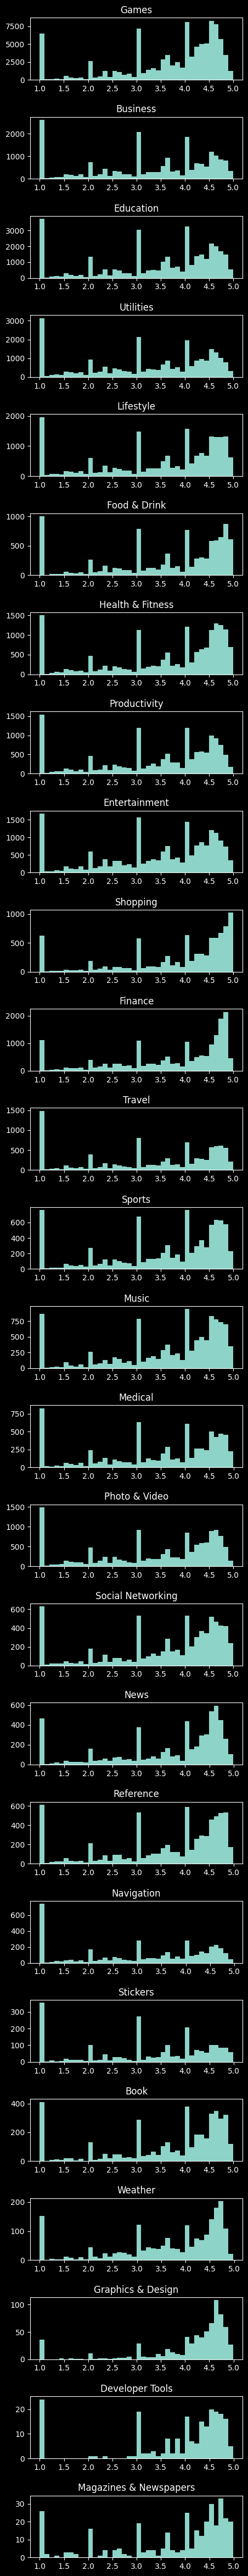

In [83]:
fig, ax = plt.subplots(26,1, figsize=(5,60))
plt.subplots_adjust(hspace=0.6)

counter = 0
for i in AppStore['Primary_Genre'].value_counts().index.to_list():
    ax[counter].hist(AppStore.loc[(AppStore['Primary_Genre']==i)&(AppStore['Average_User_Rating']>0)&(AppStore['Average_User_Rating']<5), 'Average_User_Rating'], bins=40)
    ax[counter].set_title(i)
    counter += 1

In [84]:
AppStore.groupby('Primary_Genre').mean()[['Price', 'Free', 'Average_User_Rating',
       'Reviews', 'Size_Megabytes', 'Size_Megabytes log']].sort_values('Reviews', ascending=False).to_excel('corr_matrix.xlsx')